In [3]:
import sys
import os 
from PIL import Image
import numpy as np
import pandas as pd
from PIL import Image
import cv2
sys.path.append('..')  #adds the Root Directory to the system path
from BL_CalciumAnalysis.image_analysis_methods import ImageAnalysis

In [4]:
print(sys.executable) #print the path of the Python executable being used, which should point to the Python interpreter in your Conda environment.

/opt/anaconda3/envs/biolumi_calcium_imaging/bin/python


In [7]:

from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import io
import glob
import ast 


class ImageAnalysis:
    def __init__(self, project_folder):
        self.project_folder = project_folder
        self.directory_df = self.initialize_directory_df() 
        
    def initialize_directory_df(self):
        directories = [d for d in os.listdir(self.project_folder) if os.path.isdir(os.path.join(self.project_folder, d))]
        directory_data = [{'directory_name': d, 'directory_path': os.path.join(self.project_folder, d)} for d in directories]
        return pd.DataFrame(directory_data, columns=['directory_name', 'directory_path'])
    
    def list_directories(self):
        return [d for d in os.listdir(self.project_folder) if os.path.isdir(os.path.join(self.project_folder, d))]
    
    def list_files(self, folder_name):
        folder_path = os.path.join(self.project_folder, folder_name)
        all_files = []
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                all_files.append(os.path.join(root, file))
        return all_files
    
    def generate_dark_image(self, tiff_path, num_frames=200):
        """
        Generates a median 'dark' image from the first specified number of frames in a multi-frame TIFF file.

        This method is used for compensating the dark pixel offset in bioluminescence imaging data.

        Parameters:
        tiff_path (str): Path to the multi-frame TIFF file.
        num_frames (int, optional): Number of frames to consider for generating the dark image. Defaults to 200.

        Returns:
        numpy.ndarray: A median image representing the 'dark' image.
        """
        with Image.open(tiff_path) as img:
            frames = [np.array(img.getdata(), dtype=np.float32).reshape(img.size[::-1]) for i in range(num_frames)]
            median_frame = np.median(frames, axis=0)
            return median_frame

    def subtract_dark_image(self, raw_tiff_path, dark_image):
        """
        Subtracts a 'dark' image from each frame of a multi-frame TIFF file.

        This method is used to compensate for the average dark pixel offset in bioluminescence imaging data.

        Parameters:
        raw_tiff_path (str): Path to the raw multi-frame TIFF file.
        dark_image (numpy.ndarray): The 'dark' image to be subtracted from each frame of the raw image.

        Returns:
        list of numpy.ndarray: A list of images, each representing a frame from the raw image with the dark image subtracted.
        """
        with Image.open(raw_tiff_path) as img:
            compensated_images = []
            for i in range(img.n_frames):
                img.seek(i)
                frame = np.array(img.getdata(), dtype=np.float32).reshape(img.size[::-1])
                compensated_image = cv2.subtract(frame, dark_image)
                compensated_images.append(compensated_image)
            return compensated_images
        
    def expand_directory_df(self):
        # Add new columns with default empty lists
        self.directory_df['sensor_type'] = ''
        self.directory_df['session_id'] = ''
        self.directory_df['stimulation_ids'] = [[] for _ in range(len(self.directory_df))]
        self.directory_df['stimulation_frame_number'] = [[] for _ in range(len(self.directory_df))]

        for index, row in self.directory_df.iterrows():
            folder_name = row['directory_name']
            folder_path = row['directory_path']
            
            # Parse folder name for sensor type and session id
            parts = folder_name.split('_')
            sensor_type = 'gcamp8' if parts[0].startswith('g') else 'cablam'
            session_id = parts[0][1:] + parts[1]  # Assuming the first part is always the experiment ID

            # Update DataFrame with sensor_type and session_id
            self.directory_df.at[index, 'sensor_type'] = sensor_type
            self.directory_df.at[index, 'session_id'] = session_id

            # Check for CSV file ending in 'biolumi' or 'fluor'
            csv_filename = [f for f in os.listdir(folder_path) if (f.endswith('biolumi.csv') or f.endswith('fluor.csv'))]
            if csv_filename:
                csv_file_path = os.path.join(folder_path, csv_filename[0])
                df_csv = pd.read_csv(csv_file_path, header=None)
                stimulation_ids = df_csv.iloc[1].dropna().tolist()
                stimulation_frame_number = df_csv.iloc[0].dropna().tolist()

                # Update DataFrame with stimulation information
                self.directory_df.at[index, 'stimulation_ids'] = stimulation_ids
                self.directory_df.at[index, 'stimulation_frame_number'] = stimulation_frame_number

        return self.directory_df
    
    def get_session_raw_data(self, session_id):
        # Check if the session_id is in the 'session_id' column of the directory_df
        if session_id in self.directory_df['session_id'].tolist():
            # Find the directory path for the given session_id
            directory_path = self.directory_df[self.directory_df['session_id'] == session_id]['directory_path'].values[0]
            
            # Search for the .tif file within that directory
            for file_name in os.listdir(directory_path):
                if file_name.endswith('.tif'):
                    return os.path.join(directory_path, file_name)

            # If no .tif file is found in the directory
            return f"No .tif file found in the directory for session {session_id}."
        else:
            # If the session_id is not present in the DataFrame
            return f"Session ID {session_id} is not present in the directory DataFrame."
        
    def max_projection_mean_values(self, tif_path):
        """
        Generates a maximum intensity projection based on the mean values of a multi-frame TIF file
        and saves it to a new subdirectory 'processed_data/processed_image_analysis_output'
        with a '_max_projection' suffix in the file name.

        Parameters:
        tif_path (str): Path to the multi-frame TIF file.

        Returns:
        str: Path to the saved maximum intensity projection image.
        """

        with Image.open(tif_path) as img:
            # Initialize a summing array with the shape of the first frame and float type for mean calculation
            sum_image = np.zeros((img.height, img.width), dtype=np.float32)

            # Sum up all frames
            for i in range(img.n_frames):
                img.seek(i)
                sum_image += np.array(img, dtype=np.float32)

            # Compute the mean image by dividing the sum by the number of frames
            mean_image = sum_image / img.n_frames
        
        # Define the new directory path
        processed_dir = os.path.join(os.path.dirname(tif_path), 'processed_data', 'processed_image_analysis_output')
        
        # Create the directory if it does not exist
        os.makedirs(processed_dir, exist_ok=True)
        
        # Create a new file path for the max projection image with the '_max_projection' suffix
        # The filename is extracted from tif_path and appended with '_max_projection.tif'
        file_name = os.path.basename(tif_path)
        max_proj_image_path = os.path.join(processed_dir, file_name.replace('.tif', '_max_projection.tif'))
       
        # Save the max projection image to the new file path
        Image.fromarray(mean_image).save(max_proj_image_path)

        # Return the path to the saved image
        return max_proj_image_path
    
    def analyze_all_sessions(self, function_to_apply):
        """
        Iterates over all session IDs in the directory DataFrame and applies the given function to each.

        Parameters:
        function_to_apply (callable): Function to be applied to each session. It should accept a session ID.

        Returns:
        dict: A dictionary with session_ids as keys and function return values as values.
        """
        results = {}
        for session_id in self.directory_df['session_id']:
            try:
                result = function_to_apply(session_id)
                results[session_id] = result
            except Exception as e:
                print(f"An error occurred while processing session {session_id}: {e}")
        return results
    
    def add_tiff_dimensions(self):
        """
        Analyzes the dimensions of TIF files in the directory DataFrame and adds this data as new columns.
        """
        # Ensure the DataFrame has the columns for dimensions; initialize them with None or appropriate defaults
        if 'x_dim' not in self.directory_df.columns:
            self.directory_df['x_dim'] = None
            self.directory_df['y_dim'] = None
            self.directory_df['z_dim_frames'] = None

        # Iterate over each session_id and update the dimensions
        for index, row in self.directory_df.iterrows():
            tif_path = self.get_session_raw_data(row['session_id'])
            if isinstance(tif_path, str) and tif_path.endswith('.tif'):
                try:
                    with Image.open(tif_path) as img:
                        self.directory_df.at[index, 'x_dim'] = img.width
                        self.directory_df.at[index, 'y_dim'] = img.height
                        # For z-dimension, count the frames
                        img.seek(0)  # Ensure the pointer is at the beginning
                        frames = 0
                        while True:
                            try:
                                img.seek(img.tell() + 1)
                                frames += 1
                            except EOFError:
                                break
                        self.directory_df.at[index, 'z_dim_frames'] = frames
                except Exception as e:
                    print(f"Could not process TIF dimensions for session {row['session_id']}: {e}")
    
    def analyze_roi(self, session_id):
        """
        Analyzes ROI of the 'labels_postexport.tif' file for a given session and saves two results:
        one with labels and another without labels.I t also saves the labeled image data as numpy array for future use.
        """
        
        # SETP 1: DEFINE PATHS
        # define the paths, including the directory where processed images will be saved (processed_dir) 
        # and the name of the TIF file that contains the ROI labels (consistent_file_name)
        processed_dir = 'processed_data/processed_image_analysis_output'
        consistent_file_name = 'labels_postexport.tif'
        output_suffix_with_labels = '_roi_analysis_with_labels.png'
        output_suffix_without_labels = '_roi_analysis_without_labels.png'

        # STEP 2: RETRIEVE SESSION DATA 
        # Retrieve the directory path from the DataFrame
        # looks up the session's directory path from a DataFrame (directory_df) using the provided session_id. 
        # If the session ID isn't found, it returns a message indicating no directory entry was found for that session.
        
        directory_entry = self.directory_df[self.directory_df['session_id'] == session_id]
        if directory_entry.empty:
            return f"No directory entry found for session {session_id}"

        # STEP 3: VERIFY AND LOAD THE ROI TIF FILE 
        # constructs the full path to the labels_postexport.tif file and checks if it exists. If it does, the file is opened and loaded. 
        # If the file is in RGB format, it's converted to grayscale using rgb2gray from skimage.color. 
        # This conversion is crucial for analyzing the image as a binary mask where non-white pixels are considered ROIs.
        directory_path = directory_entry['directory_path'].values[0]
        
        # Build the path to the postexport TIFF file
        tiff_file_path = os.path.join(directory_path, processed_dir, consistent_file_name)

        # Verify that the file exists
        if not os.path.exists(tiff_file_path):
            return f"File not found for session {session_id}"

        
        
        # STEP 4: CREATE AND SAVE THE BINARY MASK
        # k: The method then converts the grayscale image to a binary mask, identifying all non-white pixels as ROIs 
        # (pixels with value less than 1 after normalization are set to 1, and others to 0). 
        # This binary mask is labeled using label from skimage.measure, assigning a unique label to each connected component (ROI).
        
        # Load the image
        mask_image = Image.open(tiff_file_path)

        # Convert RGB image to grayscale if necessary
        if mask_image.mode == 'RGB':
            # Convert to grayscale using skimage's rgb2gray
            image_array = rgb2gray(np.array(mask_image))

        # Assuming that all non-white pixels are ROIs
        binary_mask = np.where(image_array < 1, 1, 0)  # Here, 1 corresponds to white in the normalized grayscale image

        # Label the regions
        labeled_image = label(binary_mask, connectivity=1)
        num_rois = np.max(labeled_image)
        
        # Save the labeled image data as a NumPy array file for future processing
        labeled_image_path = os.path.join(directory_path, processed_dir, f"{session_id}_labeled_image.npy")
        np.save(labeled_image_path, labeled_image)
        
        
        # STEP 5: SAVE THE UNLABELED ROI IMAGE 
        # Save Unlabeled ROI Image: The method saves a version of the labeled image without any annotations to a specified path (output_path_without_labels). 
        # This image is saved in the processed_image_analysis_output directory with a specific suffix to indicate it's the unlabeled version.
        
        # Save the image without labels
        output_path_without_labels = os.path.join(directory_path, processed_dir, session_id + output_suffix_without_labels)
        plt.imsave(output_path_without_labels, labeled_image, cmap='nipy_spectral')

        
        # STEP 6: ANALYZE AND SAVE LABELED ROI IMAGE 
        # Iterates through each detected region using regionprops, extracts the centroid, 
        # and annotates the image with the region's label. 
        # This annotated image is saved separately, indicating it includes ROI labels.
        
        # Analyze regions and save properties
        regions = regionprops(labeled_image)

        # Prepare to save the ROI analysis image with labels
        output_path_with_labels = os.path.join(directory_path, processed_dir, session_id + output_suffix_with_labels)
        
        fig, ax = plt.subplots()
        ax.imshow(labeled_image, cmap='nipy_spectral')
        ax.axis('off')

        # Annotate each ROI with its corresponding label (ID)
        for region in regions:
            # Get the coordinates of the centroid of the region
            y, x = region.centroid
            # Annotate the ROI ID at the centroid position
            ax.text(x, y, str(region.label), color='white', ha='center', va='center')

        plt.savefig(output_path_with_labels)
        plt.close()

        # Return the paths of the saved figures LABELED AND UNLABELED and number of ROIs
        return (output_path_with_labels, output_path_without_labels), num_rois
    
    def analyze_all_rois(self):
        """
        Applies ROI analysis to all sessions and saves the results.
        """
        results = {}
        for session_id in self.directory_df['session_id']:
            result = self.analyze_roi(session_id)
            results[session_id] = result
        return results
    
    def extract_calcium_signals(self, session_id):
        """
        Extracts calcium signals from time-series data using the saved labeled ROI mask
        and saves the results as a CSV file in the 'processed_image_analysis_output' directory.

        Parameters:
        session_id (str): Session ID for which to perform the analysis.

        Returns:
        str: Path to the saved CSV file containing calcium signal data.
        """
        processed_dir = 'processed_data/processed_image_analysis_output'
        calcium_csv_suffix = '_calcium_signals.csv'

        # Retrieve the directory path from the DataFrame
        directory_entry = self.directory_df[self.directory_df['session_id'] == session_id]
        if directory_entry.empty:
            return f"No directory entry found for session {session_id}"

        directory_path = directory_entry['directory_path'].values[0]

        # Path to the saved labeled image numpy file
        labeled_image_path = os.path.join(directory_path, processed_dir, session_id + '_labeled_image.npy')

        # Verify and load the labeled image numpy file
        if not os.path.exists(labeled_image_path):
            return f"Labeled image file not found for session {session_id}"
        labeled_image = np.load(labeled_image_path)

        # Locate and load the time-series TIFF file
        tif_files = glob.glob(os.path.join(directory_path, '*.tif'))
        tif_files = [f for f in tif_files if 'postexport' not in f and 'labels' not in f]  # Ensure it's the correct TIFF
        if not tif_files:
            return f"No time-series .tif file found in the directory for session {session_id}"
        time_series_path = tif_files[0]  # Assuming there's only one relevant TIFF file
        time_series = io.imread(time_series_path)

        # Initialize an array to store calcium signal data
        num_rois = np.max(labeled_image)
        num_frames = time_series.shape[0]
        calcium_signals = np.zeros((num_rois, num_frames))

        # Extract the signal from each ROI in each frame
        for t in range(num_frames):
            frame = time_series[t]
            for roi in range(1, num_rois + 1):
                roi_mask = labeled_image == roi
                roi_data = frame[roi_mask]
                calcium_signals[roi - 1, t] = np.mean(roi_data)

        # Create and save the DataFrame with calcium signals
        calcium_df = pd.DataFrame(calcium_signals.T, columns=[f"ROI_{i}" for i in range(1, num_rois + 1)])
        calcium_df['Frame'] = np.arange(1, num_frames + 1)
        csv_path = os.path.join(directory_path, processed_dir, session_id + calcium_csv_suffix)
        calcium_df.to_csv(csv_path, index=False)

        return csv_path
    
    def analyze_all_calcium_signals(self):
        """
        Applies calcium signal extraction to all session_ids in the directory DataFrame and stores the results.
        """
        results = {}
        for session_id in self.directory_df['session_id']:
            # Ensure the ROI analysis has been done to get the labeled images
            roi_results = self.analyze_roi(session_id)
            # Check if analyze_roi returned a path to labeled images
            if isinstance(roi_results, tuple):
                # Extract calcium signals using the labeled ROI mask
                calcium_csv_path = self.extract_calcium_signals(session_id)
                results[session_id] = calcium_csv_path
            else:
                # If roi_results is an error message, pass it through
                results[session_id] = roi_results
        return results
    
    def plot_session_calcium_signals(self, session_id):
        """
        Attempt to plot calcium signals for a given session and return a status message.

        Parameters
        ----------
        session_id : str
            The identifier for the session for which calcium signals are to be plotted.

        Returns
        -------
        str
            A message indicating whether the plotting was successful or failed. If it failed,
            the message includes the reason for the failure.
        """
        try:
            self.plot_calcium_signals(session_id)
            return f"Plotted calcium signals for session {session_id}"
        except Exception as e:
            return f"Failed to plot calcium signals for session {session_id}: {e}"
        
    def plot_all_sessions_calcium_signals(self):
        """
        Apply the plot_session_calcium_signals method to all sessions in the dataset.

        Iterates over all session IDs and plots calcium signals for each session using
        the plot_session_calcium_signals method. Collects and returns the outcomes of
        the plotting process for each session.

        Returns
        -------
        dict
            A dictionary where each key is a session ID and the corresponding value is
            a message indicating the success or failure of the plotting operation for
            that session.
        """
        results = {}
        for session_id in self.directory_df['session_id'].tolist():
            result = self.plot_session_calcium_signals(session_id)
            results[session_id] = result
        return results

    def plot_calcium_signals(self, session_id):
        processed_dir = 'processed_data/processed_image_analysis_output'
        calcium_csv_suffix = '_calcium_signals.csv'

        directory_entry = self.directory_df[self.directory_df['session_id'] == session_id]
        if directory_entry.empty:
            print(f"No directory entry found for session {session_id}")
            return

        directory_path = directory_entry['directory_path'].values[0]
        csv_path = os.path.join(directory_path, processed_dir, session_id + calcium_csv_suffix)

        if not os.path.exists(csv_path):
            print(f"Calcium signals file not found for session {session_id}")
            return

        calcium_signals_df = pd.read_csv(csv_path)
        frame_numbers = calcium_signals_df['Frame']
        calcium_signals = calcium_signals_df.drop('Frame', axis=1)

        # Normalize the signals and calculate offsets
        normalized_signals = (calcium_signals - calcium_signals.min()) / (calcium_signals.max() - calcium_signals.min())
        offsets = np.arange(len(normalized_signals.columns)) * 1.2  # Change 1.2 to the distance you want between plots

        plt.figure(figsize=(15, 10))
        
            # Access the stimulation timestamps for the session_id
        stim_frame_numbers = self.directory_df.loc[
            self.directory_df['session_id'] == session_id, 'stimulation_frame_number'
        ].values[0]

        # Add red dotted lines at the stimulation timestamps
        for frame_number in stim_frame_numbers:
            plt.axvline(x=frame_number, color='r', linestyle='--', linewidth=0.5)

        # Plot each normalized calcium signal with an offset
        for i, (roi_label, signal) in enumerate(normalized_signals.items()):
            plt.plot(frame_numbers, signal + offsets[i], label=roi_label)

        plt.xlabel('Frame Number')
        plt.ylabel('Normalized Calcium Signal (A.U.)')
        plt.title(f'Time Series of ROIs for Session {session_id}')

        # Set the y-axis ticks to the middle of the offset for each signal
        plt.yticks(ticks=offsets + 0.5, labels=normalized_signals.columns)
        
        plt.grid(False)
        plt.tight_layout()
        
        save_dir = os.path.join(directory_path, 'processed_data', 'processed_image_analysis_output')
        os.makedirs(save_dir, exist_ok=True)  # Create the directory if it does not exist
        save_path = os.path.join(save_dir, f"{session_id}_calcium_signals_plot.png")

        # Save the figure
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")
        #remove the grid line from the background of the plot
        plt.show()

    def save_individual_roi_plots(self, session_id):
        processed_dir = 'processed_data/processed_image_analysis_output'
        cell_roi_dir = 'cell_roi_processed_data'
        calcium_csv_suffix = '_calcium_signals.csv'

        # Retrieve directory path and stimulation times from DataFrame
        directory_entry = self.directory_df[self.directory_df['session_id'] == session_id]
        if directory_entry.empty:
            print(f"No directory entry found for session {session_id}")
            return

        directory_path = directory_entry['directory_path'].values[0]
        stimulation_times = directory_entry['stimulation_frame_number'].values[0]  # Access stimulation times

        processed_data_path = os.path.join(directory_path, processed_dir)
        csv_path = os.path.join(processed_data_path, session_id + calcium_csv_suffix)
        roi_output_dir = os.path.join(processed_data_path, cell_roi_dir)
        
        # Make sure the output directory exists
        os.makedirs(roi_output_dir, exist_ok=True)

        # Verify that the calcium signals file exists
        if not os.path.exists(csv_path):
            print(f"Calcium signals file not found for session {session_id}")
            return

        # Read calcium signals into DataFrame
        calcium_signals_df = pd.read_csv(csv_path)
        frame_numbers = calcium_signals_df['Frame']
        calcium_signals = calcium_signals_df.drop('Frame', axis=1)

        # Plot and save each ROI signal
        for roi_label in calcium_signals:
            plt.figure(figsize=(10, 5))
            plt.plot(frame_numbers, calcium_signals[roi_label], label=roi_label)

            # Add red dotted lines at stimulation times
            for stim_time in stimulation_times:
                plt.axvline(x=stim_time, color='red', linestyle='--', linewidth=1)

            plt.title(f"ROI {roi_label} - Session {session_id}")
            plt.xlabel('Frame Number')
            plt.ylabel('Calcium Signal Intensity')
            plt.legend()
            plt.grid(True)

            # Save the plot
            save_path = os.path.join(roi_output_dir, f"{roi_label}_signal_plot.png")
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            plt.close()

            print(f"Plot for {roi_label} saved to {save_path}")
            
    def save_individual_roi_plots_all_sessions(self):
    
        results = {}
        for session_id in self.directory_df['session_id']:
            result = self.save_individual_roi_plots(session_id)
            results[session_id] = result
        return results
            
    def plot_roi_with_zoomed_stimulations(self, session_id):
        processed_dir = 'processed_data/processed_image_analysis_output'
        calcium_csv_suffix = '_calcium_signals.csv'

        # Retrieve directory path and stimulation frames from DataFrame
        directory_entry = self.directory_df[self.directory_df['session_id'] == session_id]
        if directory_entry.empty:
            print(f"No directory entry found for session {session_id}")
            return

        directory_path = directory_entry['directory_path'].values[0]
        csv_path = os.path.join(directory_path, processed_dir, session_id + calcium_csv_suffix)
        stimulation_frames = directory_entry['stimulation_frame_number'].iloc[0]  # Used directly as a list

        # Read the calcium signals
        calcium_signals_df = pd.read_csv(csv_path)
        frame_numbers = calcium_signals_df['Frame']
        calcium_signals = calcium_signals_df.drop('Frame', axis=1)
        
        # Determine the spacing factor based on the max calcium signal value
        spacing_factor = calcium_signals.max().max() * 0.1  # For example, 10% of the max signal
        
        # Number of subplots based on the number of stimulations
        num_stimulations = len(stimulation_frames)
        num_rois = calcium_signals.shape[1]

        # Create the figure with multiple subplots
        fig, axs = plt.subplots(num_stimulations + 1, 1, figsize=(15, 5 * (num_stimulations + 1)), gridspec_kw={'height_ratios': [3] + [1]*num_stimulations})
        
        # Plot the full session signal in the first subplot
        for i, col in enumerate(calcium_signals.columns):
            axs[0].plot(frame_numbers, calcium_signals[col] + (i * spacing_factor), label=col)

        # Add stimulation markers to the full session plot
        for stim_frame in stimulation_frames:
            axs[0].axvline(x=stim_frame, color='red', linestyle='--', linewidth=1)

        # Zoom into each stimulation event in the subsequent subplots
        for i, stim_frame in enumerate(stimulation_frames, start=1):
            start_frame = max(stim_frame - 100, 0)
            end_frame = min(stim_frame + 200, len(frame_numbers))
            for j, col in enumerate(calcium_signals.columns):
                signal_segment = calcium_signals[col][start_frame:end_frame]
                frame_segment = frame_numbers[start_frame:end_frame]
                axs[i].plot(frame_segment, signal_segment + (j * spacing_factor), label=col)

            # Add a vertical line for the stimulation moment
            axs[i].axvline(x=stim_frame, color='red', linestyle='--', linewidth=1)
            axs[i].set_xlim([start_frame, end_frame])

        # Adjust the layout and save the figure
        plt.tight_layout()
        plt.show()
        save_path = os.path.join(directory_path, processed_dir, f"{session_id}_detailed_ROI_analysis.png")
        fig.savefig(save_path, dpi=300)
        plt.close(fig)

        print(f"Detailed ROI analysis figure saved to {save_path}")
        
    
        
    def plot_and_save_roi_stimulations(self, session_id):
        processed_dir = 'processed_data/processed_image_analysis_output'
        calcium_csv_suffix = '_calcium_signals.csv'
        

        # Retrieve directory path from DataFrame
        directory_entry = self.directory_df[self.directory_df['session_id'] == session_id]
        if directory_entry.empty:
            print(f"No directory entry found for session {session_id}")
            return

        directory_path = directory_entry['directory_path'].values[0]
        csv_path = os.path.join(directory_path, processed_dir, session_id + calcium_csv_suffix)

        if not os.path.exists(csv_path):
            print(f"Calcium signals file not found for session {session_id}")
            return

        # Read calcium signals into DataFrame
        calcium_signals_df = pd.read_csv(csv_path)
        frame_numbers = calcium_signals_df['Frame']
        calcium_signals = calcium_signals_df.drop('Frame', axis=1)

        # Hardcoded stimulation frames
        #stimulation_frames = [3587, 3788, 3990, 4191, 4393, 4595]
        stimulation_frames = directory_entry['stimulation_frame_number'].iloc[0]  # Used directly as a list

        # Ensure the output directory exists
        roi_output_dir = os.path.join(directory_path, processed_dir, 'cell_roi_processed_data')
        os.makedirs(roi_output_dir, exist_ok=True)

        for roi_label in calcium_signals:
            # Set up figure
            num_plots = len(stimulation_frames) + 1
            fig, axs = plt.subplots(num_plots, 1, figsize=(10, num_plots * 5))

            # Plot the full signal
            axs[0].plot(frame_numbers, calcium_signals[roi_label])
            axs[0].set_title(f"Full Session Calcium Signal for ROI {roi_label}")
            for stim_frame in stimulation_frames:
                axs[0].axvline(x=stim_frame, color='red', linestyle='--', linewidth=0.5)
            
            # Plot zoomed-in stimulations
            for idx, stim_frame in enumerate(stimulation_frames):
                zoom_start = max(stim_frame - 100, 0)
                zoom_end = min(stim_frame + 200, max(frame_numbers))
                zoomed_signal = calcium_signals[roi_label][zoom_start:zoom_end]
                zoomed_frame_numbers = frame_numbers[zoom_start:zoom_end]

                axs[idx + 1].plot(zoomed_frame_numbers, zoomed_signal)
                axs[idx + 1].axvline(x=stim_frame, color='red', linestyle='--', linewidth=0.5)
                axs[idx + 1].set_xlim(zoom_start, zoom_end)
                axs[idx + 1].set_title(f"Stimulation at Frame {stim_frame}")

            # Finalize and save figure
            plt.tight_layout()
            fig.savefig(os.path.join(roi_output_dir, f"{roi_label}_stimulation_plot.png"), dpi=300)
            plt.close()

            print(f"ROI {roi_label} plots saved in {roi_output_dir}")
            
    def plot_and_save_roi_stimulations_all_sessions(self): 
        
        results = {}
        
        for session_id in self.directory_df['session_id']:
            result = self.plot_and_save_roi_stimulations(session_id)
            results[session_id] = result
        return results
                          
    def find_responsive_rois_first_stim_mean(self, session_id, pre_stim_duration=5, post_stim_duration=5, threshold=2):
        processed_dir = 'processed_data/processed_image_analysis_output'
        calcium_csv_suffix = '_calcium_signals.csv'

        # Retrieve directory path from DataFrame
        directory_entry = self.directory_df[self.directory_df['session_id'] == session_id]
        if directory_entry.empty:
            print(f"No directory entry found for session {session_id}")
            return None

        directory_path = directory_entry['directory_path'].values[0]
        csv_path = os.path.join(directory_path, processed_dir, session_id + calcium_csv_suffix)

        if not os.path.exists(csv_path):
            print(f"Calcium signals file not found for session {session_id}")
            return None

        # Read calcium signals into DataFrame
        calcium_signals_df = pd.read_csv(csv_path)
        frame_numbers = calcium_signals_df['Frame']
        calcium_signals = calcium_signals_df.drop('Frame', axis=1)  # Explicitly drop the 'Frame' column

        # Use the hardcoded first stimulation frame
        #first_stim_frame = [3587][0]  # Hardcoded first stimulation frame
        first_stim_frame = directory_entry['stimulation_frame_number'].iloc[0][0]

        responsive_rois = []
        for roi_label in calcium_signals.columns:  # Iterate over ROI columns only
            pre_stim_signal = calcium_signals.loc[(frame_numbers >= first_stim_frame-pre_stim_duration) & (frame_numbers < first_stim_frame), roi_label]
            post_stim_signal = calcium_signals.loc[(frame_numbers >= first_stim_frame) & (frame_numbers < first_stim_frame+post_stim_duration), roi_label]

            # Calculate the z-score for the difference in means
            pre_mean = pre_stim_signal.mean()
            post_mean = post_stim_signal.mean()
            signal_change = post_mean - pre_mean

            # Standard deviation of the pre-stimulus signal
            pre_std = pre_stim_signal.std(ddof=1)  # Use ddof=1 for sample standard deviation
            # Calculate the z-score
            if pre_std > 0:
                z_score = signal_change / pre_std
            else:
                z_score = 0
            
            #if abs(z_score) > threshold: # for absolute z-score
            if z_score > threshold: # for positive z-score
                responsive_rois.append(roi_label)
                print(f"ROI {roi_label} is responsive. Change: {signal_change:.2f}, Z-score: {z_score:.2f}")


        return responsive_rois
    
    def plot_responsive_rois_around_stim(self, session_id, pre_stim_duration=100, post_stim_duration=200, threshold=2):
        responsive_rois = self.find_responsive_rois_first_stim_mean(session_id, pre_stim_duration=3, post_stim_duration=3, threshold=threshold)

        if not responsive_rois:
            print("No responsive ROIs found.")
            return

        processed_dir = 'processed_data/processed_image_analysis_output'
        calcium_csv_suffix = '_calcium_signals.csv'
        directory_entry = self.directory_df[self.directory_df['session_id'] == session_id]
        directory_path = directory_entry['directory_path'].values[0]
        csv_path = os.path.join(directory_path, processed_dir, session_id + calcium_csv_suffix)

        calcium_signals_df = pd.read_csv(csv_path)
        #first_stim_frame = 3587  # Update this based on your actual first stim frame
        first_stim_frame = directory_entry['stimulation_frame_number'].iloc[0][0]

        plt.figure(figsize=(10, 6))

        for roi_label in responsive_rois:
            if roi_label in calcium_signals_df.columns:
                roi_data = calcium_signals_df[[roi_label, 'Frame']]
                
                # Select data around the stimulation point
                stim_start = max(first_stim_frame - pre_stim_duration, 0)
                stim_end = min(first_stim_frame + post_stim_duration, max(calcium_signals_df['Frame']))
                
                roi_segment = roi_data[(roi_data['Frame'] >= stim_start) & (roi_data['Frame'] <= stim_end)]
                
                plt.plot(roi_segment['Frame'], roi_segment[roi_label], label=f'ROI {roi_label}')
                plt.axvline(x=first_stim_frame, color='red', linestyle='--')

        plt.xlabel('Frame Number')
        plt.ylabel('Signal Intensity')
        plt.title(f'Calcium Signals Around First Stimulation for Responsive ROIs in Session {session_id}')
        plt.legend()
        plt.tight_layout()

        save_path = os.path.join(directory_path, processed_dir, f"{session_id}_responsive_ROIs_around_stim.png")
        plt.savefig(save_path, dpi=300)
        plt.close()

        print(f"Plot saved at {save_path}")
        
    def plot_mean_and_sem_of_responsive_rois(self, session_id, pre_stim_duration=100, post_stim_duration=200, threshold=2):
        responsive_rois = self.find_responsive_rois_first_stim_mean(session_id, pre_stim_duration, post_stim_duration, threshold)

        if not responsive_rois:
            print("No responsive ROIs found with a positive z-score.")
            return

        processed_dir = 'processed_data/processed_image_analysis_output'
        calcium_csv_suffix = '_calcium_signals.csv'
        directory_entry = self.directory_df[self.directory_df['session_id'] == session_id]
        directory_path = directory_entry['directory_path'].values[0]
        csv_path = os.path.join(directory_path, processed_dir, session_id + calcium_csv_suffix)

        calcium_signals_df = pd.read_csv(csv_path)
        frame_numbers = calcium_signals_df['Frame']
        
        first_stim_frame = directory_entry['stimulation_frame_number'].iloc[0][0]  # Assuming the first element is the first stim frame

        # Plot setup
        plt.figure(figsize=(10, 6))
        
        #Compute mean and SEM only for the responsive ROIs
        mean_response = calcium_signals_df[responsive_rois].mean(axis=1)
        sem_response = calcium_signals_df[responsive_rois].sem(axis=1)

        # Focus on the time around the first stimulation
        stim_start = max(frame_numbers.searchsorted(first_stim_frame - pre_stim_duration), 0)
        stim_end = min(frame_numbers.searchsorted(first_stim_frame + post_stim_duration), len(frame_numbers) - 1)
        
        # Extract the segment for plotting
        frame_segment = frame_numbers.iloc[stim_start:stim_end + 1]
        mean_segment = mean_response.iloc[stim_start:stim_end + 1]
        sem_segment = sem_response.iloc[stim_start:stim_end + 1]

        plt.figure(figsize=(10, 6))
        plt.errorbar(frame_segment, mean_segment, yerr=sem_segment, fmt='-', color='blue', ecolor='lightblue', label='Mean +/- SEM')

        # Stimulation line
        plt.axvline(x=first_stim_frame, color='red', linestyle='--', label='First Stimulus')

        # Labels and title
        plt.xlabel('Frame Number')
        plt.ylabel('Calcium Signal Intensity')
        plt.title(f'Calcium Signals Around First Stimulation for Responsive ROIs in Session {session_id}')
        plt.legend()
        plt.tight_layout()

        # Save the plot
        save_path = os.path.join(directory_path, processed_dir, f"{session_id}_responsive_ROIs_mean_sem.png")
        plt.savefig(save_path, dpi=300)
        plt.close()

        print(f"Plot saved at {save_path}")
        
    def plot_normalized_mean_and_sem_of_responsive_rois(self, session_id, pre_stim_duration=100, post_stim_duration=200, threshold=2):
        responsive_rois = self.find_responsive_rois_first_stim_mean(session_id, pre_stim_duration, post_stim_duration, threshold)

        if not responsive_rois:
            print("No responsive ROIs found with a positive z-score.")
            return

        processed_dir = 'processed_data/processed_image_analysis_output'
        calcium_csv_suffix = '_calcium_signals.csv'
        directory_entry = self.directory_df[self.directory_df['session_id'] == session_id]
        directory_path = directory_entry['directory_path'].values[0]
        csv_path = os.path.join(directory_path, processed_dir, session_id + calcium_csv_suffix)

        calcium_signals_df = pd.read_csv(csv_path)
        first_stim_frame = directory_entry['stimulation_frame_number'].iloc[0][0]  # Assuming the first element is the first stim frame

        # Normalize the signals for each responsive ROI
        normalized_signals = calcium_signals_df[responsive_rois].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

        # Compute mean and SEM for the normalized signals
        mean_normalized_response = normalized_signals.mean(axis=1)
        sem_normalized_response = normalized_signals.sem(axis=1)

        # Focus on the time around the first stimulation
        stim_start = max(first_stim_frame - pre_stim_duration, 0)
        stim_end = min(first_stim_frame + post_stim_duration, len(calcium_signals_df))

        # Corrected plotting section:
        frame_mask = (calcium_signals_df['Frame'] >= stim_start-9) & (calcium_signals_df['Frame'] <= stim_end+100)

        plt.figure(figsize=(10, 6))
        plt.errorbar(calcium_signals_df.loc[frame_mask, 'Frame'], 
                    mean_normalized_response.loc[frame_mask], 
                    yerr=sem_normalized_response.loc[frame_mask], 
                    label='Normalized Mean +/- SEM', 
                    color='blue', 
                    ecolor='lightblue')



        # Stimulation line
        plt.axvline(x=first_stim_frame-1, color='red', linestyle='--', label='First Stimulus')

        # Labels and title
        plt.xlabel('Frame Number')
        plt.ylabel('Normalized Calcium Signal Intensity')
        plt.title(f'Normalized Calcium Signals Around First Stimulation for Responsive ROIs in Session {session_id}')
        plt.legend()
        plt.tight_layout()

        # Save the plot
        save_path = os.path.join(directory_path, processed_dir, f"{session_id}_responsive_ROIs_normalized_mean_sem.png")
        plt.savefig(save_path, dpi=300)
        plt.close()

        print(f"Normalized plot saved at {save_path}")

    def plot_normalized_mean_and_sem_of_all_stims(self, session_id, pre_stim_duration=100, post_stim_duration=200, threshold=2):
        responsive_rois = self.find_responsive_rois_first_stim_mean(session_id, pre_stim_duration, post_stim_duration, threshold)

        if not responsive_rois:
            print("No responsive ROIs found with a positive z-score.")
            return

        processed_dir = 'processed_data/processed_image_analysis_output'
        calcium_csv_suffix = '_calcium_signals.csv'
        directory_entry = self.directory_df[self.directory_df['session_id'] == session_id]
        directory_path = directory_entry['directory_path'].values[0]
        csv_path = os.path.join(directory_path, processed_dir, session_id + calcium_csv_suffix)

        calcium_signals_df = pd.read_csv(csv_path)
        stimulation_frames = directory_entry['stimulation_frame_number'].iloc[0]

        # Normalize the signals for each responsive ROI
        normalized_signals = calcium_signals_df[responsive_rois].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

        # Create a composite figure with subplots for each stimulation
        num_stimulations = len(stimulation_frames)
        
        # Initialize numpy arrays for storing mean and SEM data
        # Determine the response window size (modify this logic based on how you decide to handle edge cases)
        response_window_size = pre_stim_duration + post_stim_duration
        mean_responses = np.zeros((num_stimulations, response_window_size))
        sem_responses = np.zeros((num_stimulations, response_window_size))
        
        
        
        fig, axs = plt.subplots(num_stimulations, 1, figsize=(10, 6 * num_stimulations))

        for i, stim_frame in enumerate(stimulation_frames):
            # Compute mean and SEM for the normalized signals focusing on the time around the stimulation
            stim_start = max(stim_frame - pre_stim_duration, 0)
            stim_end = min(stim_frame + post_stim_duration, len(calcium_signals_df))

            frame_mask = (calcium_signals_df['Frame'] >= stim_start-9) & (calcium_signals_df['Frame'] <= stim_end+100)
            mean_normalized_response = normalized_signals.loc[frame_mask].mean(axis=1)
            sem_normalized_response = normalized_signals.loc[frame_mask].sem(axis=1)
            
            # Truncate or pad the response if necessary (this example assumes padding with zeros)
            response_length = len(mean_normalized_response)
            #print the length of the response
            if response_length == response_window_size:
                mean_responses[i, :] = mean_normalized_response.values
                sem_responses[i, :] = sem_normalized_response.values
            else:
                # If the response length is less, pad the rest; if more, truncate (shouldn't occur with correct mask)
                padded_mean = np.pad(mean_normalized_response.values, (0, response_window_size - response_length), 'constant', constant_values=(0, 0))
                padded_sem = np.pad(sem_normalized_response.values, (0, response_window_size - response_length), 'constant', constant_values=(0, 0))
                mean_responses[i, :] = padded_mean
                sem_responses[i, :] = padded_sem

            # Frame numbers for plotting
            frame_numbers_for_plot = calcium_signals_df.loc[frame_mask, 'Frame']

            # Filling between the SEM range around the mean
            axs[i].fill_between(frame_numbers_for_plot,
                                mean_normalized_response - sem_normalized_response,
                                mean_normalized_response + sem_normalized_response,
                                color='lightblue', alpha=0.5, label='SEM')

            axs[i].plot(frame_numbers_for_plot,
                        mean_normalized_response,
                        color='blue', label=f'Normalized Mean (Stim {i+1})')

            axs[i].axvline(x=stim_frame-1, color='red', linestyle='--', label='Stimulus')
            axs[i].set_xlabel('Frame Number')
            axs[i].set_ylabel('Normalized Calcium Signal Intensity')
            axs[i].set_title(f'Normalized Signals Around Stim {i+1} for Responsive ROIs in Session {session_id}')
            axs[i].legend()

            plt.tight_layout()

        # Save the composite figure
        save_path = os.path.join(directory_path, processed_dir, f"{session_id}_all_stims_responsive_ROIs_normalized_mean_sem.png")
        fig.savefig(save_path, dpi=300)
        plt.close(fig)
        
        # Save the numpy arrays for later use
        np.save(os.path.join(directory_path, processed_dir, f"{session_id}_mean_responses.npy"), mean_responses)
        np.save(os.path.join(directory_path, processed_dir, f"{session_id}_sem_responses.npy"), sem_responses)

        print(f"Composite normalized plot saved and Mean and SEM response data saved at {save_path}")
        
    def plot_overlaid_normalized_responses(self, session_id, pre_stim_duration=100, post_stim_duration=200, threshold=2):
        responsive_rois = self.find_responsive_rois_first_stim_mean(session_id, pre_stim_duration, post_stim_duration, threshold)

        if not responsive_rois:
            print("No responsive ROIs found with a positive z-score.")
            return

        processed_dir = 'processed_data/processed_image_analysis_output'
        calcium_csv_suffix = '_calcium_signals.csv'
        directory_entry = self.directory_df[self.directory_df['session_id'] == session_id]
        directory_path = directory_entry['directory_path'].values[0]
        csv_path = os.path.join(directory_path, processed_dir, session_id + calcium_csv_suffix)
        stimulation_frames = directory_entry['stimulation_frame_number'].iloc[0]

        calcium_signals_df = pd.read_csv(csv_path)
        normalized_signals = calcium_signals_df[responsive_rois].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

        plt.figure(figsize=(10, 6))
        colors = plt.cm.viridis(np.linspace(0, 1, len(stimulation_frames)))  # Color map for different stim intensities

        for i, (stim_frame, color) in enumerate(zip(stimulation_frames, colors)):
            stim_start = max(stim_frame - pre_stim_duration, 0)
            stim_end = min(stim_frame + post_stim_duration, len(calcium_signals_df))

            frame_mask = (calcium_signals_df['Frame'] >= stim_start-9) & (calcium_signals_df['Frame'] <= stim_end+100)
            mean_normalized_response = normalized_signals.loc[frame_mask].mean(axis=1)
            sem_normalized_response = normalized_signals.loc[frame_mask].sem(axis=1)

            # Plotting the mean response with shaded SEM
            frame_numbers_for_plot = calcium_signals_df.loc[frame_mask, 'Frame']
            plt.fill_between(frame_numbers_for_plot,
                            mean_normalized_response - sem_normalized_response,
                            mean_normalized_response + sem_normalized_response,
                            color=color, alpha=0.5)

            plt.plot(frame_numbers_for_plot,
                    mean_normalized_response,
                    color=color, label=f'Stim {i+1}')

        plt.axvline(x=stimulation_frames[0]-1, color='red', linestyle='--', label='First Stimulus')
        plt.xlabel('Frame Number')
        plt.ylabel('Normalized Calcium Signal Intensity')
        plt.title(f'Overlaid Normalized Responses for Responsive ROIs in Session {session_id}')
        plt.legend()
        plt.tight_layout()

        save_path = os.path.join(directory_path, processed_dir, f"{session_id}_overlaid_normalized_responses.png")
        plt.savefig(save_path, dpi=300)
        plt.close()

        print(f"Overlaid normalized responses plot saved at {save_path}")
        
    def plot_mean_responses_from_file(self, session_id):
        processed_dir = 'processed_data/processed_image_analysis_output'
        directory_entry = self.directory_df[self.directory_df['session_id'] == session_id]
        directory_path = directory_entry['directory_path'].values[0]
        
        # Construct the file path and load the data
        mean_responses_path = os.path.join(directory_path, processed_dir, f"{session_id}_mean_responses.npy")
        mean_responses = np.load(mean_responses_path)
        

        # Check if mean_responses is empty or not
        if mean_responses.size == 0:
            print("No data found in the mean responses file.")
            return
        
        #print the shape of the mean_responses
        print(mean_responses.shape)
        
        num_stimulations = mean_responses.shape[0]
        response_window_size = mean_responses.shape[1]
        
        # Plotting
        plt.figure(figsize=(10, 6))
        for i in range(num_stimulations):
            plt.plot(mean_responses[i, :], label=f'Stim {i+1}')
        
        plt.xlabel('Time Point')
        plt.ylabel('Normalized Mean Response')
        plt.title(f'Normalized Mean Responses for All Stimulations in Session {session_id}')
        plt.legend()
        plt.tight_layout()
        plt.show()


    def create_trial_locked_calcium_signals(self, session_id):
        """
         dictionary with session IDs as keys. Each session contains its own dictionary with keys for stim_frame_numbers, roi_data, and stimulation_ids. 
        Within roi_data, the data is keyed by tuples, where each tuple consists of a stimulation_id and a stim_frame_number, 
        and associated with these tuples are NumPy arrays of the recorded signals.
        
        Outline of dictionary structure:
        Level 1: The top-level dictionary contains Session IDs as keys.
        Example: '2312072023', '1112072023'
        
        Level 2: Each Session ID key maps to a dictionary that contains three keys:
        'stim_frame_numbers': List of frame numbers where stimuli were applied.
        'roi_data': Nested dictionary with ROI signal data.
        'stimulation_ids': List of identifiers for each stimulus type.
       
        Level 3: The 'roi_data' dictionary has:
        Keys: Names of the ROIs (e.g., 'ROI_1').
        Values: Another dictionary for each ROI, which I'll describe in the next level.
        
        Level 4 (within 'roi_data'): Here's where the tuple comes into play.
        Keys: Tuples containing (stimulation_id, stim_frame_number).
        stimulation_id: A unique identifier for the type of stimulation.
        stim_frame_number: The frame number when this stimulation occurred.
        Values: NumPy arrays with the calcium signal data corresponding to each ROI following a stimulus event.
        
        all_data : dict
        A dictionary containing processed calcium signal data for multiple sessions.

        Each key in `all_data` represents a unique session ID corresponding to an individual experimental session.

        Keys
        ----
        session_id : str
            A unique identifier for the experimental session. The `session_id` is likely a string that represents the date and additional identifying information of the session.

        Values
        ------
        A dictionary containing the following keys:

        stim_frame_numbers : list of int
            A list of integers representing the frame numbers at which stimuli were applied.

        roi_data : dict of dict
            A nested dictionary where each top-level key is an ROI label (e.g., 'ROI_1') and the value is another dictionary mapping a tuple of `(stimulation_id, stim_frame_number)` to a NumPy array of signal data.

            Keys
            ----
            (stimulation_id, stim_frame_number) : tuple
                `stimulation_id` : int
                    An integer representing a unique identifier for a type of stimulus applied during the experimental session.

                `stim_frame_number` : int
                    An integer indicating the frame number at which the stimulus was applied.

            Values
            ------
            signal_data : numpy.ndarray
                An array containing the calcium signal values recorded for the ROI after the corresponding stimulus event.

        stimulation_ids : list of int
            A list of unique identifiers for each type of stimulation used in the session.

        Example
        -------
        >>> all_data['2312072023']['stim_frame_numbers']
        [3582, 3784, 3986, 4187, 4389, 4590, 4792, 4994, 5195, 5397]
        >>> all_data['2312072023']['roi_data']['ROI_1'][(60, 3582)]
        array([...signal values...])
        >>> all_data['2312072023']['stimulation_ids']
        [12, 24, 36, 60, 120, 480]
        """
        
        
        processed_dir = 'processed_data/processed_image_analysis_output'
        calcium_csv_suffix = '_calcium_signals.csv'

        directory_entry = self.directory_df[self.directory_df['session_id'] == session_id] #pull out the entry for the given session_id from the directory dataframe
        
        #pull out the list of stimulation frame numbers for the given session_id under the stimulation_frame_number column
        stim_frame_numbers = directory_entry['stimulation_frame_number'].values[0]
        
        #pull out the stimulation label for the given session_id under the stimulation_label column
        stimulation_ids = directory_entry['stimulation_ids'].values[0]
        
        if directory_entry.empty:
            print(f"No directory entry found for session {session_id}")
            return

        directory_path = directory_entry['directory_path'].values[0]
        csv_path = os.path.join(directory_path, processed_dir, session_id + calcium_csv_suffix)

        if not os.path.exists(csv_path):
            print(f"Calcium signals file not found for session {session_id}")
            return

        calcium_signals_df = pd.read_csv(csv_path) #import the calcium signals csv file 
        #convert the values in the calcium_signals dataframe to integers with no decimal points
        calcium_signals_df = calcium_signals_df.astype(int)
        
        # Parameters for alignment
        pre_stim_frames = 10  # Number of frames before stimulation to include
        post_stim_frames = 100  # Number of frames after stimulation to include
        
        # Create a nested dictionary where each key-value pair corresponds to a different ROI. 
        # For each ROI, you have another dictionary where the key is a tuple of (stimulation_id, stim_frame_number), 
        # and the value is a NumPy array containing the calcium signal values for a window around the stimulation frame.

        # Initialize a nested dictionary to hold ROI, stimulation ID and frame number, and data
        roi_data = {roi: {} for roi in calcium_signals_df.columns if 'ROI' in roi}

        # Loop through each stimulation frame number and their corresponding stimulation IDs
        for stim_id, stim_frame in zip(stimulation_ids, stim_frame_numbers):
            # Calculate the index range for frames to extract
            start_idx = max(stim_frame - pre_stim_frames, 0)  # Ensure index is not negative
            end_idx = min(stim_frame + post_stim_frames, len(calcium_signals_df))  # Ensure index is within range

            # Loop through each ROI column
            for roi in roi_data:
                # Extract the relevant section of the calcium signals for the ROI
                trial = calcium_signals_df.loc[start_idx:end_idx, roi]

                # Store the trial data as a NumPy array in the nested dictionary
                # Using a tuple of (stimulation_id, stim_frame_number) as the key
                roi_data[roi][(stim_id, stim_frame)] = trial.to_numpy().astype(int)
        
        return  stim_frame_numbers, roi_data, stimulation_ids
    
    def process_all_sessions(self):
        all_data = {}
        # Iterate over all unique session IDs
        for session_id in self.directory_df['session_id'].unique():
            # Adjusted to unpack three values here
            stim_frame_numbers, roi_data, stimulation_ids = self.create_trial_locked_calcium_signals(session_id)
            all_data[session_id] = {
                'stim_frame_numbers': stim_frame_numbers,
                'roi_data': roi_data,
                'stimulation_ids': stimulation_ids  # You can decide whether you need to store this or not
            }
        return all_data
    
    def preprocess_and_extract_signals(self, session_id):
        """
        Renamed and extended functionality to include pre-processing of bioluminescence video data.
        Corrects the "Dark signal" for each ROI by calculating the mean of the first 100 frames
        of the signal and subtracts this value for each ROI from the entire series. Negative 
        values resulting from this subtraction are set as NaN.

        Parameters
        ----------
        session_id : str
            Unique identifier for the experimental session.

        Returns
        -------
        dict
            A dictionary containing processed and extracted calcium signal data for the session.
        """
        
        
            
        processed_dir = 'processed_data/processed_image_analysis_output'
        calcium_csv_suffix = '_calcium_signals.csv'

        directory_entry = self.directory_df[self.directory_df['session_id'] == session_id] #pull out the entry for the given session_id from the directory dataframe
            
            #pull out the list of stimulation frame numbers for the given session_id under the stimulation_frame_number column
        stim_frame_numbers = directory_entry['stimulation_frame_number'].values[0]
            
            #pull out the stimulation label for the given session_id under the stimulation_label column
        stimulation_ids = directory_entry['stimulation_ids'].values[0]
            
        if directory_entry.empty:
            print(f"No directory entry found for session {session_id}")
            return

        directory_path = directory_entry['directory_path'].values[0]
        csv_path = os.path.join(directory_path, processed_dir, session_id + calcium_csv_suffix)

        if not os.path.exists(csv_path):
            print(f"Calcium signals file not found for session {session_id}")
            return
        
        # ... (existing code remains unchanged up to calcium_signals_df loading)

        calcium_signals_df = pd.read_csv(csv_path) #import the calcium signals csv file
        
        # Correct the "Dark signal" for each ROI
        for roi in calcium_signals_df.columns:
            if 'ROI' in roi:  # Assuming ROI columns are prefixed with 'ROI'
                # Calculate the mean of the first 100 frames for the dark signal
                dark_signal_mean = calcium_signals_df[roi][:100].mean()
                # Subtract the dark signal mean from the entire series for this ROI
                calcium_signals_df[roi] = calcium_signals_df[roi] - dark_signal_mean
                # Set negative values to NaN
                calcium_signals_df.loc[calcium_signals_df[roi] < 0, roi] = np.nan

        # Convert the values in the calcium_signals dataframe to integers with no decimal points
        # Note: This may not be applicable anymore since you will have NaNs after correction
        # calcium_signals_df = calcium_signals_df.astype(int)
        
        # ... (the rest of your existing code for extracting trial-locked signals)
        #convert the values in the calcium_signals dataframe to integers with no decimal points
            calcium_signals_df = calcium_signals_df.astype(int)
            
            # Parameters for alignment
            pre_stim_frames = 10  # Number of frames before stimulation to include
            post_stim_frames = 100  # Number of frames after stimulation to include
            
            # Create a nested dictionary where each key-value pair corresponds to a different ROI. 
            # For each ROI, you have another dictionary where the key is a tuple of (stimulation_id, stim_frame_number), 
            # and the value is a NumPy array containing the calcium signal values for a window around the stimulation frame.

            # Initialize a nested dictionary to hold ROI, stimulation ID and frame number, and data
            roi_data = {roi: {} for roi in calcium_signals_df.columns if 'ROI' in roi}

            # Loop through each stimulation frame number and their corresponding stimulation IDs
            for stim_id, stim_frame in zip(stimulation_ids, stim_frame_numbers):
                # Calculate the index range for frames to extract
                start_idx = max(stim_frame - pre_stim_frames, 0)  # Ensure index is not negative
                end_idx = min(stim_frame + post_stim_frames, len(calcium_signals_df))  # Ensure index is within range

                # Loop through each ROI column
                for roi in roi_data:
                    # Extract the relevant section of the calcium signals for the ROI
                    trial = calcium_signals_df.loc[start_idx:end_idx, roi]

                    # Store the trial data as a NumPy array in the nested dictionary
                    # Using a tuple of (stimulation_id, stim_frame_number) as the key
                    roi_data[roi][(stim_id, stim_frame)] = trial.to_numpy().astype(int)
            
        return  stim_frame_numbers, roi_data, stimulation_ids


In [9]:
#instantiates an ImageAnalysis object
project_folder = '/Volumes/MannySSD/cablam_imaging/raw_data_for_analysis' #path to the folder containing the raw data to be analyzed (i.e. the folder containing the folders for each experiment)
analysis = ImageAnalysis(project_folder)





print(analysis.directory_df)
analysis.directory_df

#expand the directory dataframe with the new columns
analysis.expand_directory_df()



                    directory_name  \
0   g23_12072023_estim_10hz_na_blk   
1   g11_12072023_estim_10hz_na_blk   
2   g13_12092023_estim_10hz_na_blk   
3     c12_12242023_estim_10hz_1xfz   
4     c12_12232023_estim_10hz_1xfz   
5     c22_12232023_estim_10hz_1xfz   
6     c21_12232023_estim_10hz_1xfz   
7     c11_12242023_estim_10hz_1xfz   
8   g12_12092023_estim_10hz_na_blk   
9     c23_12232023_estim_10hz_1xfz   
10    c13_12242023_estim_10hz_1xfz   
11   c21_12242023_estim_10hz_05xfz   
12   c22_12242023_estim_10hz_05xfz   
13   c23_12242023_estim_10hz_05xfz   

                                       directory_path  
0   /Volumes/MannySSD/cablam_imaging/raw_data_for_...  
1   /Volumes/MannySSD/cablam_imaging/raw_data_for_...  
2   /Volumes/MannySSD/cablam_imaging/raw_data_for_...  
3   /Volumes/MannySSD/cablam_imaging/raw_data_for_...  
4   /Volumes/MannySSD/cablam_imaging/raw_data_for_...  
5   /Volumes/MannySSD/cablam_imaging/raw_data_for_...  
6   /Volumes/MannySSD/cablam_imaging/

,directory_name,directory_path,sensor_type,session_id,stimulation_ids,stimulation_frame_number
0,g23_12072023_estim_10hz_na_blk,/Volumes/MannySSD/cablam_imaging/raw_data_for_...,gcamp8,2312072023,"[60, 60, 60, 60, 60, 60, 60, 60, 60, 60]","[3582, 3784, 3986, 4187, 4389, 4590, 4792, 499..."
1,g11_12072023_estim_10hz_na_blk,/Volumes/MannySSD/cablam_imaging/raw_data_for_...,gcamp8,1112072023,"[36, 36, 36, 36, 36, 36, 36, 36, 36, 36]","[2387, 2789, 3192, 3595, 3997, 4400, 4803, 520..."
2,g13_12092023_estim_10hz_na_blk,/Volumes/MannySSD/cablam_imaging/raw_data_for_...,gcamp8,1312092023,"[12, 24, 36, 60, 120, 480]","[3599, 3800, 4001, 4203, 4404, 4607]"
3,c12_12242023_estim_10hz_1xfz,/Volumes/MannySSD/cablam_imaging/raw_data_for_...,cablam,1212242023,"[12, 24, 36, 60, 120, 240, 480, 960, 1920]","[3589, 3991, 4393, 4796, 5198, 5602, 6006, 641..."
4,c12_12232023_estim_10hz_1xfz,/Volumes/MannySSD/cablam_imaging/raw_data_for_...,cablam,1212232023,"[12, 24, 36, 60, 120, 480]","[3587, 3788, 3990, 4191, 4393, 4595]"
5,c22_12232023_estim_10hz_1xfz,/Volumes/MannySSD/cablam_imaging/raw_data_for_...,cablam,2212232023,"[12, 24, 36, 60, 120, 240, 480, 960, 1920]","[3583, 3985, 4387, 4789, 5192, 5595, 6000, 640..."
6,c21_12232023_estim_10hz_1xfz,/Volumes/MannySSD/cablam_imaging/raw_data_for_...,cablam,2112232023,"[12, 24, 36, 60, 120, 240, 480, 960, 1920]","[3509, 3911, 4313, 4715, 5118, 5521, 5926, 633..."
7,c11_12242023_estim_10hz_1xfz,/Volumes/MannySSD/cablam_imaging/raw_data_for_...,cablam,1112242023,"[12, 24, 36, 60, 120, 240, 480, 960, 1920]","[3597, 3999, 4402, 4804, 5207, 5610, 6014, 642..."
8,g12_12092023_estim_10hz_na_blk,/Volumes/MannySSD/cablam_imaging/raw_data_for_...,gcamp8,1212092023,"[12, 24, 36, 60, 120, 480]","[3579, 3780, 3982, 4183, 4385, 4587]"
9,c23_12232023_estim_10hz_1xfz,/Volumes/MannySSD/cablam_imaging/raw_data_for_...,cablam,2312232023,"[12, 24, 36, 60, 120, 240, 480, 960, 1920]","[3592, 3994, 4396, 4799, 5202, 5605, 6009, 641..."


In [14]:
analysis_cablam = ImageAnalysis(project_folder)
analysis_cablam.directory_df = analysis.directory_df[(analysis.directory_df['sensor_type'] == 'cablam') & (analysis.directory_df['directory_name'].str.contains('05xfz'))]
analysis_cablam.directory_df

analysis_gcamp8 = ImageAnalysis(project_folder)
analysis_gcamp8.directory_df = analysis.directory_df[(analysis.directory_df['sensor_type'] == 'gcamp8')]
analysis_gcamp8.directory_df


,directory_name,directory_path,sensor_type,session_id,stimulation_ids,stimulation_frame_number
0,g23_12072023_estim_10hz_na_blk,/Volumes/MannySSD/cablam_imaging/raw_data_for_...,gcamp8,2312072023,"[60, 60, 60, 60, 60, 60, 60, 60, 60, 60]","[3582, 3784, 3986, 4187, 4389, 4590, 4792, 499..."
1,g11_12072023_estim_10hz_na_blk,/Volumes/MannySSD/cablam_imaging/raw_data_for_...,gcamp8,1112072023,"[36, 36, 36, 36, 36, 36, 36, 36, 36, 36]","[2387, 2789, 3192, 3595, 3997, 4400, 4803, 520..."
2,g13_12092023_estim_10hz_na_blk,/Volumes/MannySSD/cablam_imaging/raw_data_for_...,gcamp8,1312092023,"[12, 24, 36, 60, 120, 480]","[3599, 3800, 4001, 4203, 4404, 4607]"
8,g12_12092023_estim_10hz_na_blk,/Volumes/MannySSD/cablam_imaging/raw_data_for_...,gcamp8,1212092023,"[12, 24, 36, 60, 120, 480]","[3579, 3780, 3982, 4183, 4385, 4587]"


In [46]:
session_ids = analysis.directory_df['session_id']
print(session_ids)


0     2312072023
1     1112072023
2     1312092023
3     1212242023
4     1212232023
5     2212232023
6     2112232023
7     1112242023
8     1212092023
9     2312232023
10    1312242023
11    2112242023
12    2212242023
13    2312242023
Name: session_id, dtype: object


In [ ]:
# Usage example with a given session_id, assuming the session_id is present in the directory DataFrame and has a .tif file
session_id = '1212232023'  # Replace with your actual session_id
raw_data_path = analysis.get_session_raw_data(session_id) #get the raw data path for the given session_id

# below is the code to generate the max projection image for the raw data at the raw_data_path 
if raw_data_path and not raw_data_path.startswith("No .tif file"): #if the raw data path was found and does not start with "No .tif file"
    max_proj_image = analysis.max_projection_mean_values(raw_data_path) #generate the max projection image 


In [ ]:
# Assuming you've already initialized your ImageAnalysis instance and populated directory_df:
analysis.add_tiff_dimensions()

# Now the directory_df has the dimensions for each TIFF file included
print(analysis.directory_df.head())  # Display the updated DataFrame to verify


In [ ]:
analysis.directory_df

In [ ]:
# run the analysis on all sessions in the directory_df

#define a wrapper function to apply the max_projection_mean_values method to all sessions
def analyze_session_max_projection(session_id):
    """
    Wrapper function to apply max_projection_mean_values to a session's TIF file.

    Parameters:
    session_id (str): The session ID for which the TIF file will be processed.

    Returns:
    str: Path to the processed max projection TIFF file.
    """
    # analysis is an instance of ImageAnalysis
    tif_path = analysis.get_session_raw_data(session_id)
    if isinstance(tif_path, str) and tif_path.endswith('.tif'):
        return analysis.max_projection_mean_values(tif_path)
    else:
        return f"No valid TIF file found for session {session_id}"# Apply max_projection_mean_values to all sessions

results = analysis.analyze_all_sessions(analyze_session_max_projection)

# Output the results
for session_id, result_path in results.items():
    if isinstance(result_path, str):
        print(f"Session ID {session_id}: Max projection image saved at {result_path}")
    else:
        print(f"Session ID {session_id}: {result_path}")

In [ ]:
# Analyze ROIs for all sessions
analysis.analyze_all_rois()

In [ ]:
# extract the calcium signal for a given session_id

session_id = '1212232023'  # Replace with your actual session_id
calcium_signals_path = analysis.extract_calcium_signals(session_id)
print(f"Calcium signals saved at: {calcium_signals_path}")


In [ ]:
#extract calcium signals for all sessions in the directory_df, confirms the location of the saved calcium signals and the location of the saved calcium signals

all_results = analysis.analyze_all_calcium_signals()

for session_id, csv_path in all_results.items():
    if isinstance(csv_path, str):
        print(f"Session {session_id} - Calcium signals saved at: {csv_path}")
    else:
        print(f"Session {session_id} - Error: {csv_path}")

In [15]:

#for the analysis object directroy_df attribute, edit the df to only work with sensor_type cablam
#analysis.directory_df = analysis.directory_df[analysis.directory_df['sensor_type'] == 'gcamp8'] 

#for the analysis object directroy_df attribute, edit the df to only work with sensor_type cablam annd if the directory_name has 1xfz in it 
analysis.directory_df = analysis.directory_df[(analysis.directory_df['sensor_type'] == 'cablam') & (analysis.directory_df['directory_name'].str.contains('05xfz'))]

analysis.directory_df
all_data = analysis.process_all_sessions()
all_data_gcamp8 = analysis_gcamp8.process_all_sessions()
all_data_cablam = analysis_cablam.process_all_sessions()



In [16]:
all_data
all_data_gcamp8
all_data_cablam


{'2112242023': {'stim_frame_numbers': [3592,
   3994,
   4397,
   4799,
   5202,
   5605,
   6009,
   6416,
   6828],
  'roi_data': {'ROI_1': {(12,
     3592): array([514, 512, 513, 514, 514, 513, 514, 513, 515, 515, 513, 517, 516,
           516, 514, 516, 516, 514, 515, 514, 512, 515, 512, 512, 515, 512,
           510, 509, 512, 510, 514, 513, 514, 511, 513, 511, 512, 512, 514,
           512, 510, 510, 512, 511, 513, 514, 515, 513, 513, 512, 512, 511,
           513, 512, 514, 511, 511, 512, 511, 511, 515, 513, 513, 514, 513,
           511, 513, 511, 513, 514, 512, 515, 512, 513, 514, 512, 513, 513,
           511, 513, 513, 514, 512, 513, 515, 512, 509, 513, 513, 514, 513,
           513, 512, 514, 513, 514, 511, 515, 512, 510, 511, 510, 513, 515,
           516, 515, 514, 514, 514, 511, 511]),
    (24,
     3994): array([512, 512, 512, 512, 512, 512, 515, 511, 512, 509, 511, 515, 515,
           515, 516, 511, 510, 514, 511, 513, 515, 512, 514, 516, 513, 514,
           512, 512

Plotting for session 2112242023


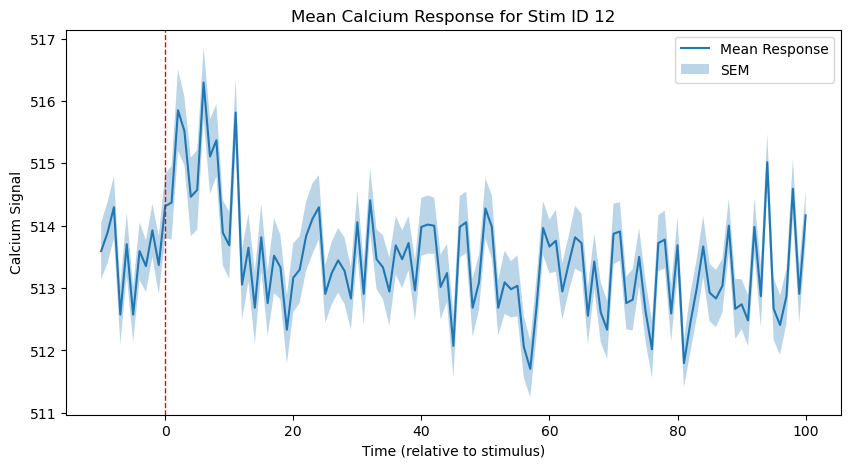

Plotting for session 2212242023


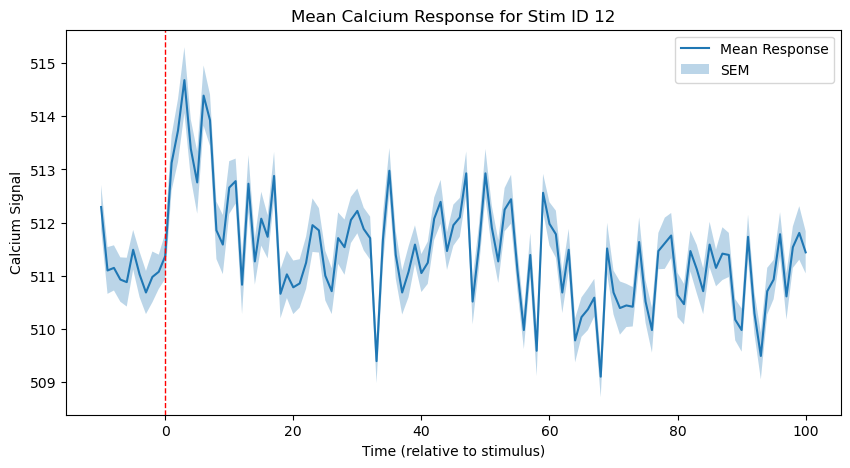

Plotting for session 2312242023


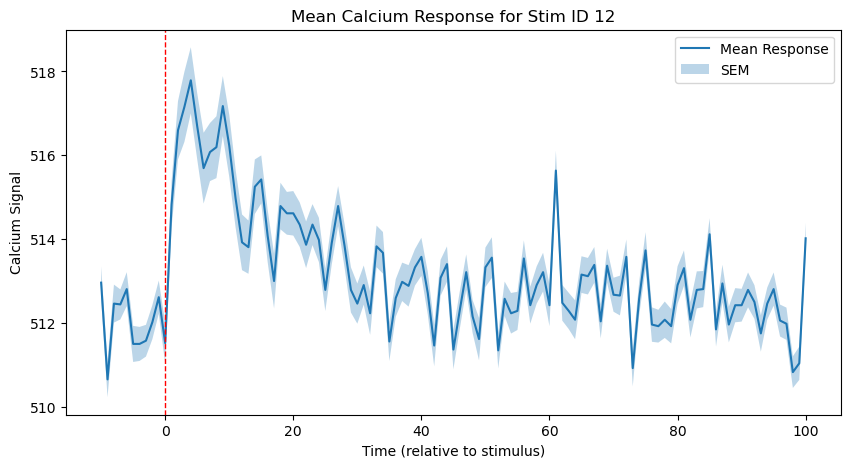

In [77]:
#this function plots the mean respnonse for each session giveb a specific stim_id

def plot_mean_response_for_session(roi_data, stim_id):
    """
    Plots the mean response for a given stim_id across all ROIs for a single session's data.

    :param roi_data: The roi_data for a single session (a dictionary with ROIs as keys and data as values).
    :param stim_id: The stimulation ID to plot data for.
    """
    selected_data = {}
    for roi, stim_data in roi_data.items():
        for (current_stim_id, _), data in stim_data.items():
            if current_stim_id == stim_id:
                selected_data[roi] = data

    # Ensure there is data to plot
    if not selected_data:
        print(f"No data found for stim_id {stim_id}")
        return

    stacked_data = np.stack(list(selected_data.values()))
    mean_response = np.mean(stacked_data, axis=0)
    sem_response = np.std(stacked_data, axis=0, ddof=1) / np.sqrt(stacked_data.shape[0])

    time_points = np.arange(-10, 101)  # Assuming the same time range as before

    plt.figure(figsize=(10, 5))
    plt.plot(time_points, mean_response, label='Mean Response')
    plt.fill_between(time_points, mean_response - sem_response, mean_response + sem_response, alpha=0.3, label='SEM')
    
    #add red dotted lines at time point 0 
    plt.axvline(x=0, color='red', linestyle='--', linewidth=1)   
    
    plt.xlabel('Time (relative to stimulus)')
    plt.ylabel('Calcium Signal')
    plt.title(f'Mean Calcium Response for Stim ID {stim_id}')
    plt.legend()
    plt.show()

# Now to iterate over all sessions and plot for a specific stim_id
def plot_all_sessions(all_data, stim_id=12):
    for session_id, session_data in all_data.items():
        print(f"Plotting for session {session_id}")
        plot_mean_response_for_session(session_data['roi_data'], stim_id)
        
#run the plot_all_sessions function
plot_all_sessions(all_data, stim_id=12)



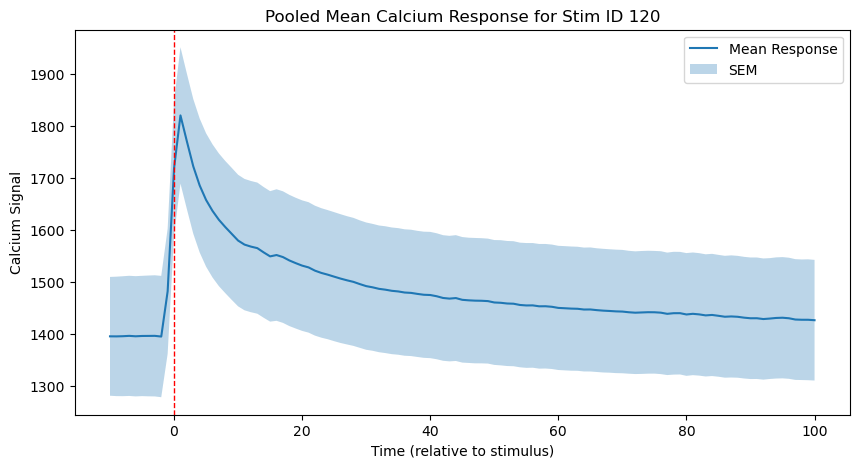

In [17]:

def plot_pooled_responses(all_data, stim_id):
    """
    Plots the mean response for a given stim_id pooled across all ROIs and all sessions.

    :param all_data: The dictionary containing all session data.
    :param stim_id: The stimulation ID to plot data for.
    """
    pooled_data = []
    
    # Aggregate data for the specific stim_id across all sessions and ROIs
    for session_id, session_data in all_data.items():
        roi_data = session_data['roi_data']
        for roi, stim_data in roi_data.items():
            for (current_stim_id, _), data in stim_data.items():
                if current_stim_id == stim_id:
                    pooled_data.append(data)
                    
    # Check if there is any data collected for the stim_id
    if not pooled_data:
        print(f"No data found for stim_id {stim_id} across sessions")
        return

    # Stack the pooled data and calculate the mean and SEM
    stacked_data = np.stack(pooled_data)
    mean_response = np.mean(stacked_data, axis=0)
    sem_response = np.std(stacked_data, axis=0, ddof=1) / np.sqrt(stacked_data.shape[0])

    time_points = np.arange(-10, 101)  # Adjust according to your pre/post frames

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(time_points, mean_response, label='Mean Response')
    
    #add red dotted lines at time point 0 
    plt.axvline(x=0, color='red', linestyle='--', linewidth=1)   
    plt.fill_between(time_points, mean_response - sem_response, mean_response + sem_response, alpha=0.3, label='SEM')
    plt.xlabel('Time (relative to stimulus)')
    plt.ylabel('Calcium Signal')
    plt.title(f'Pooled Mean Calcium Response for Stim ID {stim_id}')
    plt.legend()
    plt.show()

# Now you can call this function with all_data and the desired stim_id
plot_pooled_responses(all_data, stim_id=120)


In [18]:
def compile_pooled_responses(all_data):
    """
    Compiles the mean response and SEM for each stim_id pooled across all ROIs and all sessions.

    :param all_data: The dictionary containing all session data.
    :return: A dictionary with the pooled mean responses and SEMs.
    """
    pooled_responses = {}

    # Get all unique stim_ids from the data
    unique_stim_ids = set()
    for session_data in all_data.values():
        for roi_data in session_data['roi_data'].values():
            unique_stim_ids.update(stim_id for stim_id, _ in roi_data.keys())

    # Aggregate and calculate data for each stim_id
    for stim_id in unique_stim_ids:
        pooled_data = []
        for session_id, session_data in all_data.items():
            roi_data = session_data['roi_data']
            for roi, stim_data in roi_data.items():
                for (current_stim_id, _), data in stim_data.items():
                    if current_stim_id == stim_id:
                        pooled_data.append(data)

        # Check if there is any data collected for the stim_id
        if pooled_data:
            # Stack the pooled data and calculate the mean and SEM
            stacked_data = np.stack(pooled_data)
            mean_response = np.mean(stacked_data, axis=0)
            sem_response = np.std(stacked_data, axis=0, ddof=1) / np.sqrt(stacked_data.shape[0])

            # Store the mean response and SEM in the dictionary
            if stim_id not in pooled_responses:
                pooled_responses[stim_id] = {}
            pooled_responses[stim_id]['mean_response'] = mean_response
            pooled_responses[stim_id]['sem_response'] = sem_response

    return pooled_responses

# Use the function to get the pooled responses
pooled_responses = compile_pooled_responses(all_data)


In [19]:
#combine the all_data_gcamp8 and all_data_cablam dictionaries for the pooled responses
pooled_responses_gcamp8 = compile_pooled_responses(all_data_gcamp8)
pooled_responses_cablam = compile_pooled_responses(all_data_cablam)


In [71]:
pooled_responses

{480: {'mean_response': array([515.71118012, 514.44099379, 514.98757764, 514.67701863,
         514.52484472, 515.29813665, 514.88819876, 515.0621118 ,
         515.0310559 , 515.16459627, 515.95341615, 517.63354037,
         519.51863354, 521.36024845, 522.94409938, 525.58074534,
         527.54968944, 528.26086957, 529.58695652, 531.23602484,
         532.00621118, 532.3136646 , 532.78571429, 534.0931677 ,
         533.9689441 , 533.64906832, 534.03726708, 534.39130435,
         534.83850932, 534.77639752, 535.05900621, 534.22049689,
         534.54037267, 534.76708075, 533.87267081, 533.66149068,
         534.31055901, 533.33229814, 533.35403727, 533.16459627,
         532.07142857, 532.19875776, 532.42236025, 531.58074534,
         532.        , 531.79192547, 530.83229814, 530.12732919,
         530.48757764, 529.81987578, 528.78571429, 529.11490683,
         528.72360248, 528.73602484, 528.63043478, 528.00931677,
         528.25776398, 526.60559006, 527.23602484, 527.06521739,
   

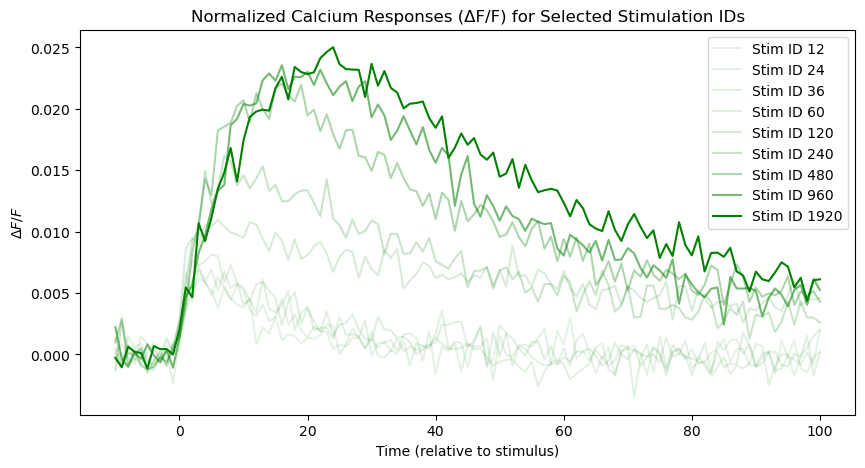

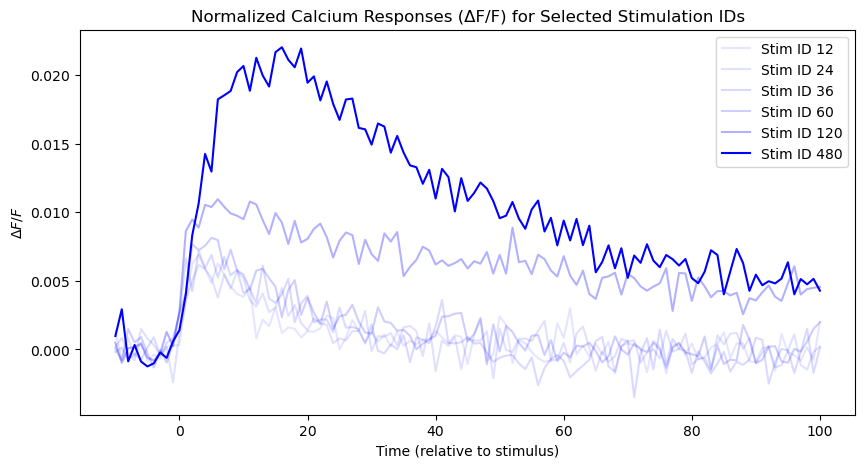

In [43]:
import matplotlib.pyplot as plt
import numpy as np

def plot_delta_f_over_f(pooled_responses, specific_stim_ids=None, base_color='green'):
    """
    Plots the normalized calcium responses (ΔF/F) for all or specific stimulation IDs,
    with the line opacity reflecting the intensity of the stimulation ID.
    
    Parameters
    ----------
    pooled_responses : dict
        A dictionary with stim IDs as keys and 'mean_response' and 'sem_response' as subkeys.
    specific_stim_ids : list of int, optional
        A list of stimulation IDs to be plotted. If None (default), all stim IDs will be plotted.
        If an invalid stim ID is provided, a ValueError will be raised.
    base_color : str, optional
        The color of the plot lines. Default is 'green'. This function will adjust the opacity of this color
        based on the stimulation ID intensity.
    
    Raises
    ------
    ValueError
        If a specified stim ID is not present in the data.
    
    Examples
    --------
    >>> plot_delta_f_over_f(pooled_responses) # Plots all responses with varying opacity of green color
    >>> plot_delta_f_over_f(pooled_responses, specific_stim_ids=[12, 24, 36], base_color='blue')
        # Plots responses for stim IDs 12, 24, and 36 with varying opacity of blue color
    """
    plt.figure(figsize=(10, 5))
    
    # Check if specific_stim_ids have been provided
    if specific_stim_ids is not None:
        # Verify that the provided stim IDs are valid
        invalid_stim_ids = set(specific_stim_ids) - set(pooled_responses.keys())
        if invalid_stim_ids:
            raise ValueError(f"Invalid stim IDs provided: {invalid_stim_ids}")
        stim_ids = specific_stim_ids
    else:
        stim_ids = sorted(pooled_responses.keys())
    
    # Get the minimum and maximum stim IDs for normalization
    min_stim_id, max_stim_id = min(stim_ids), max(stim_ids)

    # Plot the responses
    for stim_id in stim_ids:
        response = pooled_responses[stim_id]['mean_response']
        baseline = np.mean(response[:10])  # Adjust this index to match the pre-stimulus period
        delta_f_over_f = (response - baseline) / baseline
        
        # Normalize the stim_id to get an alpha value between 0.1 and 1.0
        alpha = 0.1 + 0.9 * (stim_id - min_stim_id) / (max_stim_id - min_stim_id)

        time_points = np.arange(-10, len(response) - 10)  # Adjust the range as necessary

        plt.plot(time_points, delta_f_over_f, label=f'Stim ID {stim_id}', color=base_color, alpha=alpha)

    plt.xlabel('Time (relative to stimulus)')
    plt.ylabel(r'$\Delta F/F$')
    plt.title('Normalized Calcium Responses (ΔF/F) for Selected Stimulation IDs')
    plt.legend()
    plt.show()

# Example usage:
plot_delta_f_over_f(pooled_responses, base_color='green')
plot_delta_f_over_f(pooled_responses, specific_stim_ids=[12, 24, 36, 60, 120, 480], base_color='blue')


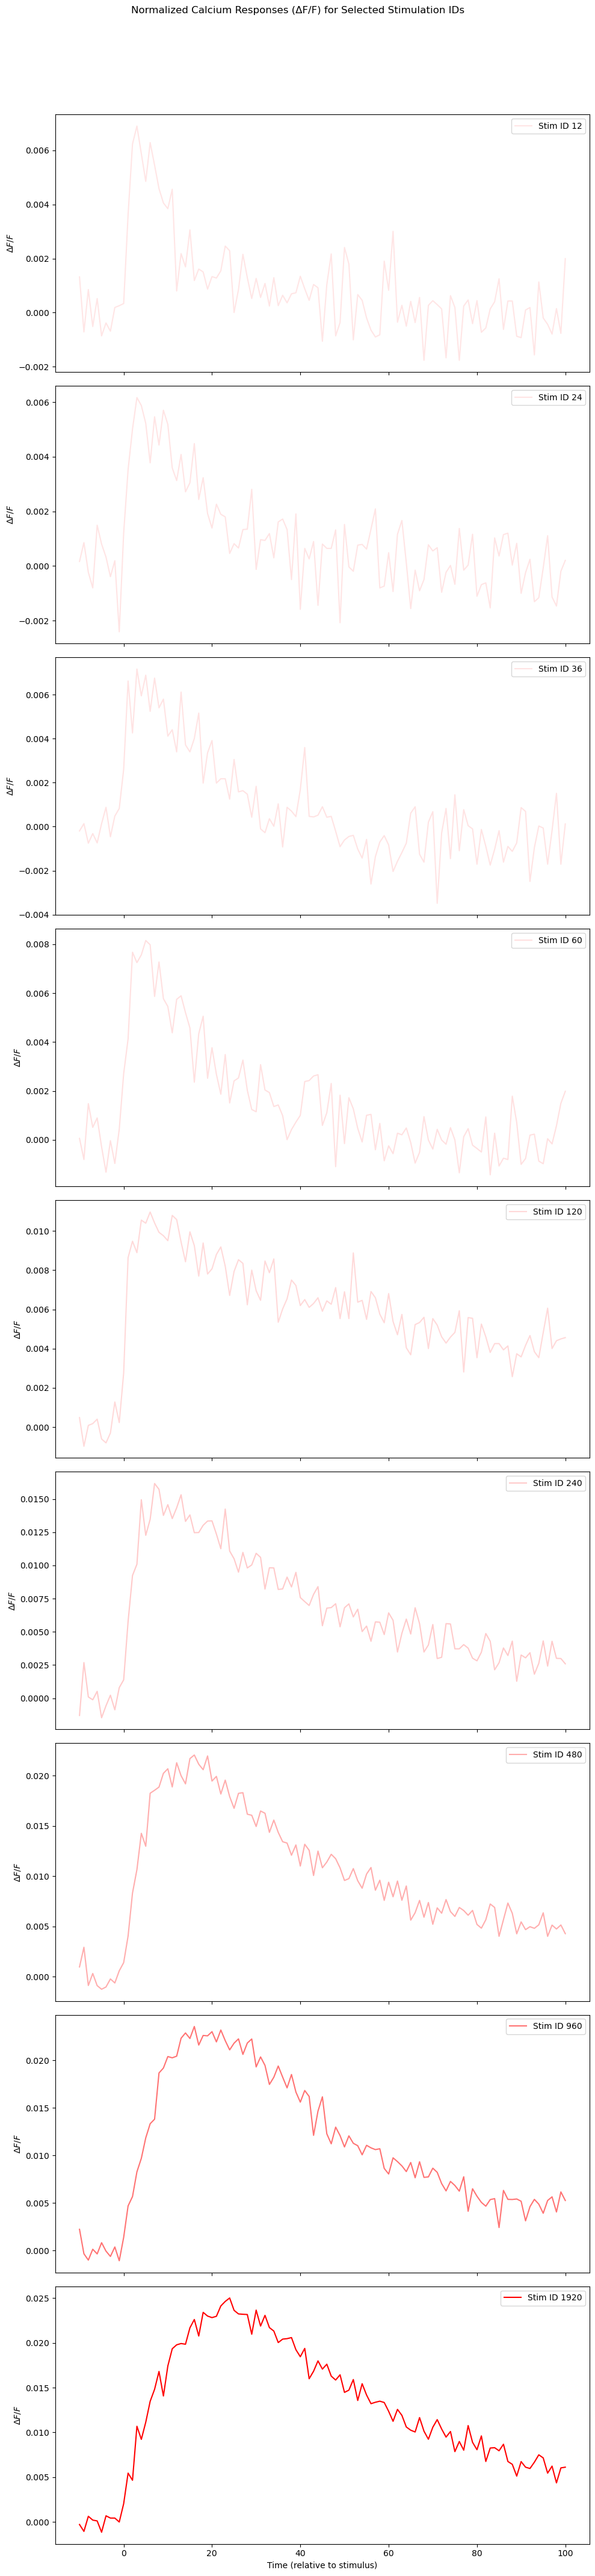

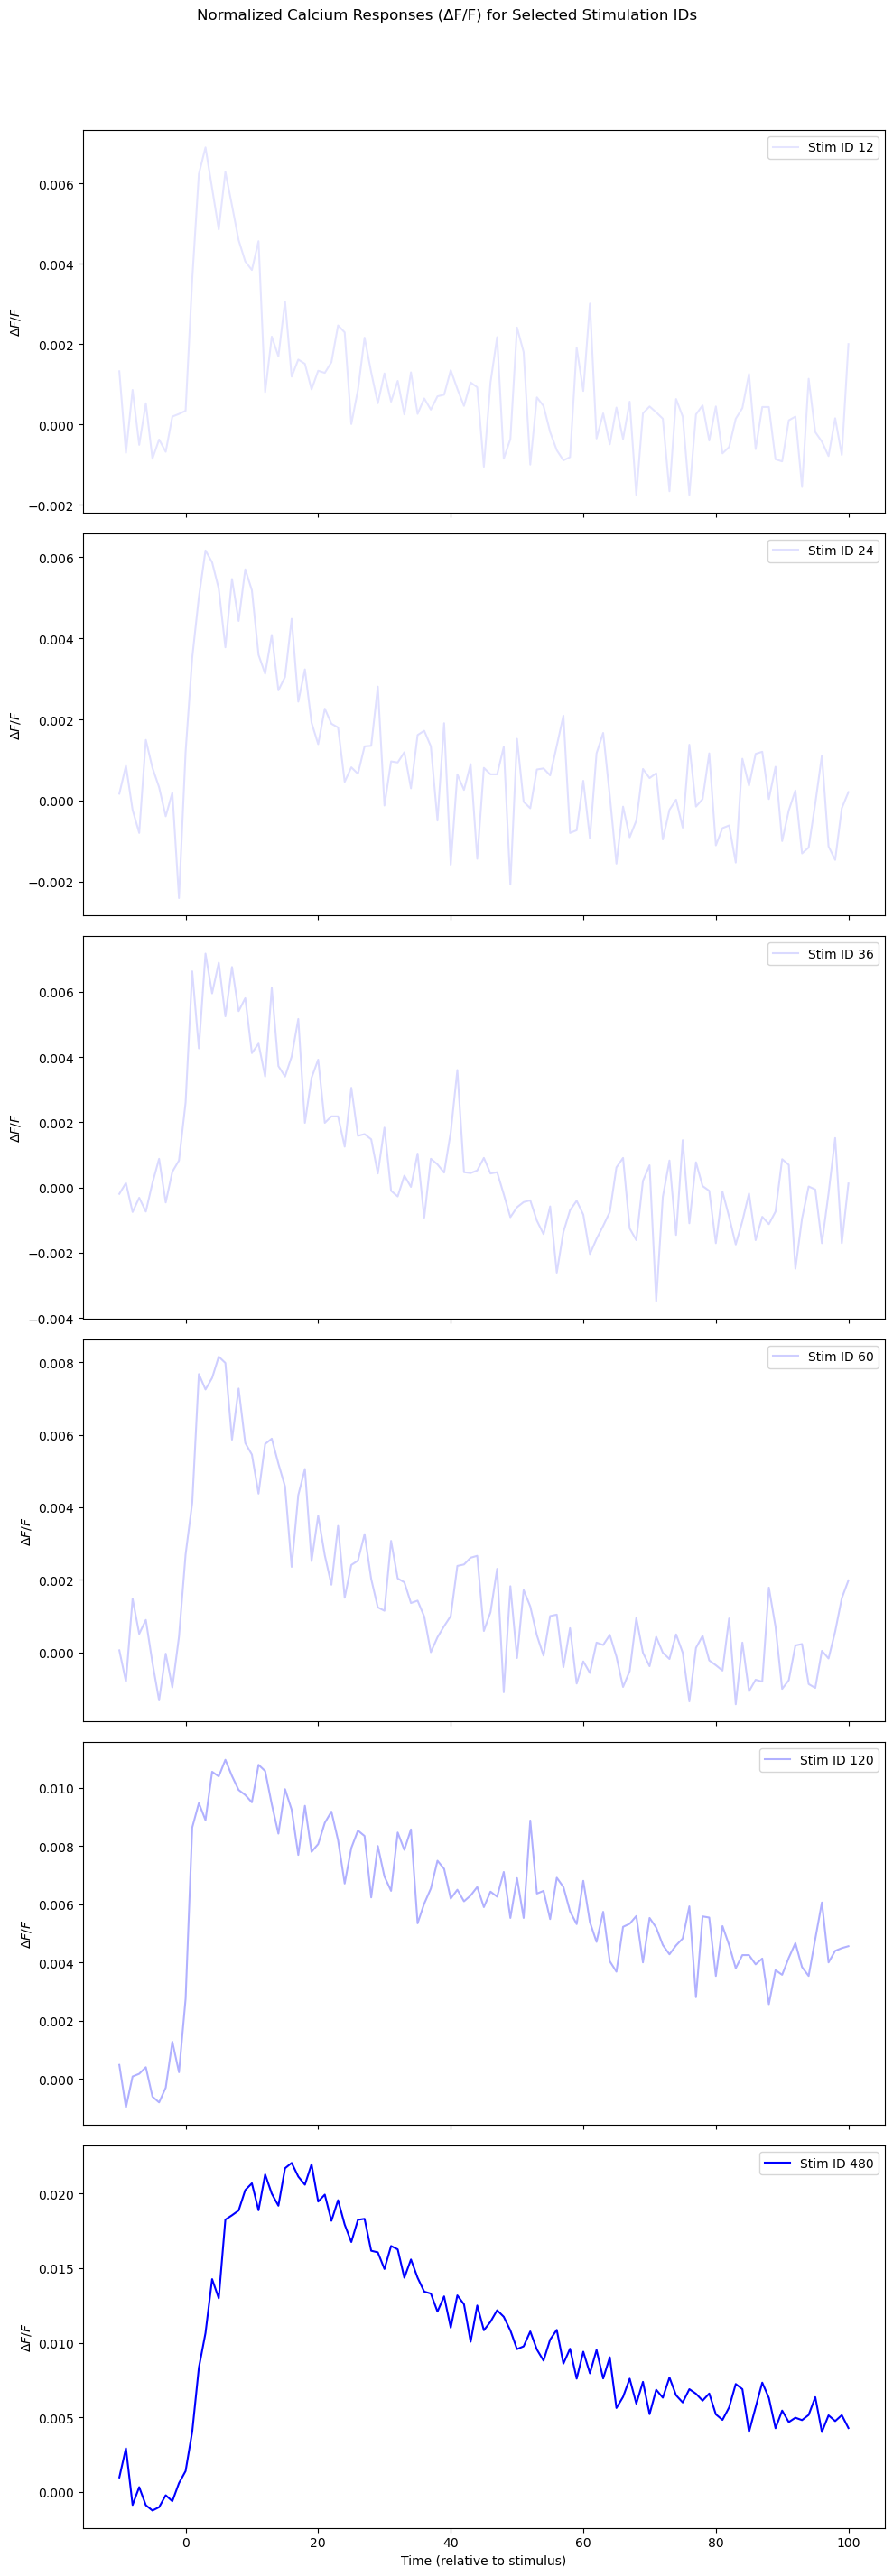

In [41]:
import matplotlib.pyplot as plt
import numpy as np

def plot_delta_f_over_f_subplots(pooled_responses, specific_stim_ids=None, base_color='green'):
    """
    Plots normalized calcium responses (ΔF/F) for all or specific stimulation IDs as subplots,
    with the line opacity reflecting the intensity of the stimulation ID.
    
    Parameters
    ----------
    pooled_responses : dict
        A dictionary with stim IDs as keys and 'mean_response' and 'sem_response' as subkeys.
    specific_stim_ids : list of int, optional
        A list of stimulation IDs to be plotted. If None (default), all stim IDs will be plotted.
        If an invalid stim ID is provided, a ValueError will be raised.
    base_color : str, optional
        The color of the plot lines. Default is 'green'. This function will adjust the opacity of this color
        based on the stimulation ID intensity.
    
    Raises
    ------
    ValueError
        If a specified stim ID is not present in the data.
    
    Examples
    --------
    >>> plot_delta_f_over_f_subplots(pooled_responses) # Plots all responses as subplots with green lines
    >>> plot_delta_f_over_f_subplots(pooled_responses, specific_stim_ids=[12, 24, 36], base_color='blue')
        # Plots responses for stim IDs 12, 24, and 36 as subplots with blue lines
    """
    # Check if specific_stim_ids have been provided
    if specific_stim_ids is not None:
        # Verify that the provided stim IDs are valid
        invalid_stim_ids = set(specific_stim_ids) - set(pooled_responses.keys())
        if invalid_stim_ids:
            raise ValueError(f"Invalid stim IDs provided: {invalid_stim_ids}")
        stim_ids = specific_stim_ids
    else:
        stim_ids = sorted(pooled_responses.keys())
    
    # Determine the number of subplots based on the number of stim IDs
    num_subplots = len(stim_ids)
    fig, axes = plt.subplots(num_subplots, 1, figsize=(10, 5 * num_subplots), sharex=True)
    
    if num_subplots == 1:
        axes = [axes]  # Make sure axes is iterable for a single subplot case

    # Get the min and max stim IDs for opacity scaling
    min_stim_id, max_stim_id = min(stim_ids), max(stim_ids)
    
    for ax, stim_id in zip(axes, stim_ids):
        response = pooled_responses[stim_id]['mean_response']
        baseline = np.mean(response[:10])  # Adjust this index to match the pre-stimulus period
        delta_f_over_f = (response - baseline) / baseline
        
        # Normalize the stim_id to get an alpha value between 0.1 and 1.0
        alpha = 0.1 + 0.9 * (stim_id - min_stim_id) / (max_stim_id - min_stim_id)

        time_points = np.arange(-10, len(response) - 10)  # Adjust the range as necessary

        ax.plot(time_points, delta_f_over_f, label=f'Stim ID {stim_id}', color=base_color, alpha=alpha)
        ax.set_ylabel(r'$\Delta F/F$')
        ax.legend()

    # Set the xlabel for the last subplot
    axes[-1].set_xlabel('Time (relative to stimulus)')
    plt.suptitle('Normalized Calcium Responses (ΔF/F) for Selected Stimulation IDs')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to accommodate the suptitle
    plt.show()

# Example usage:
plot_delta_f_over_f_subplots(pooled_responses, base_color='red')
plot_delta_f_over_f_subplots(pooled_responses, specific_stim_ids=[12, 24, 36, 60, 120, 480], base_color='blue')


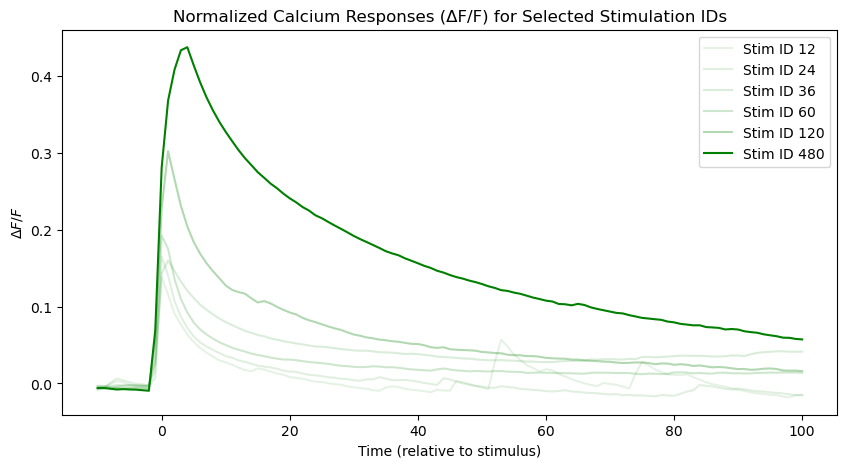

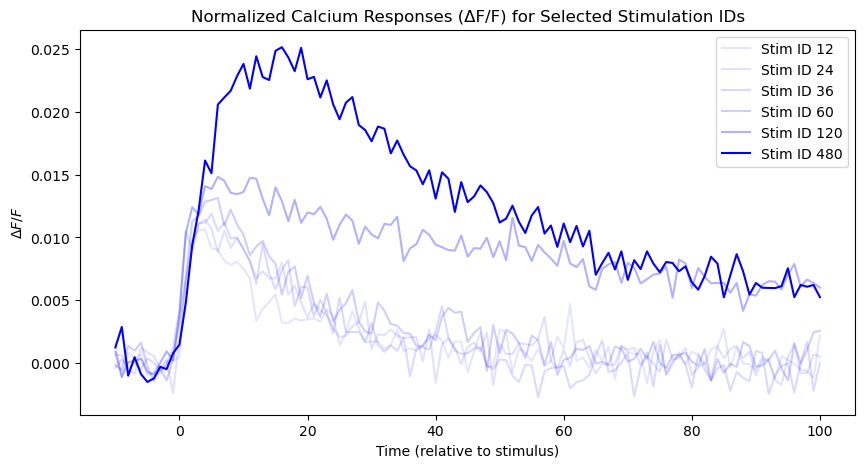

In [69]:

import numpy as np
import pandas as pd
from scipy.stats import ttest_ind

def calculate_responsiveness(all_data, pre_stim_frames=10, post_stim_frames=10, alpha=0.01, return_dataframe=False):
    """
    This function calculates and identifies responsive cells within calcium imaging data, applying statistical 
    tests to determine whether the change in signal post-stimulation is significant compared to the pre-stimulation 
    baseline. It stores detailed metrics including means, standard deviations, and p-values for each ROI across all sessions.

    Parameters:
    - all_data (dict): Nested dictionary containing the processed calcium signal data for multiple sessions, 
      structured with session IDs as top-level keys.
    - pre_stim_frames (int): The number of frames before the stimulus used to calculate the baseline signal.
    - post_stim_frames (int): The number of frames after the stimulus used for post-stimulus signal analysis.
    - alpha (float): The significance level used to determine if a response is statistically significant.
    - return_dataframe (bool): If set to True, the function also returns a pandas DataFrame containing the computed metrics.

    Returns:
    - dict: A nested dictionary containing calculated metrics for each session ID, ROI, and stimulus event. If 
      `return_dataframe` is True, it also returns a DataFrame alongside this dictionary.

    The output dictionary follows a multi-level structure:
    - Level 1 (Session Level): Keys are session IDs, and values are dictionaries containing data for each session.
    - Level 2 (ROI Level): Within each session dictionary, keys are ROIs, and values are dictionaries with metrics for each ROI.
    - Level 3 (Stimulus Event Level): For each ROI, keys are tuples of (stimulation_id, stim_frame_number), and values 
      are dictionaries containing the metrics calculated for each stimulus event.

    Metrics included for each stimulus event:
    - 'pre_stim_mean': Mean of the signal in the pre-stimulus period.
    - 'pre_stim_sd': Standard deviation of the signal in the pre-stimulus period.
    - 'post_stim_peak': Maximum signal value in the post-stimulus period (not normalized).
    - 'post_stim_sd': Standard deviation of the signal in the post-stimulus period, excluding the peak value.
    - 'p_value': P-value from the t-test comparing pre-stimulus and post-stimulus signals.
    - 'is_responsive': Boolean indicating whether the ROI is considered responsive based on the p-value being below alpha.

    
    Returns:
    dict or (dict, pd.DataFrame): A dictionary and optionally a DataFrame containing all metrics and SDs for each session ID, ROI, and stimulus.
    """
    responsiveness_data = {}
    dataframe_rows = []

    for session_id, session_data in all_data.items():
        session_responsiveness = {}
        for roi, roi_data in session_data['roi_data'].items():
            roi_responsiveness = {}
            for (stim_id, stim_frame), signal_data in roi_data.items():
                # Validate signal_data length
                if signal_data.size >= (pre_stim_frames + post_stim_frames + 1):
                    pre_stim_signal = signal_data[:pre_stim_frames]
                    post_stim_signal = signal_data[pre_stim_frames + 1 : pre_stim_frames + 1 + post_stim_frames]

                    # Calculate means and SDs
                    pre_stim_mean = np.mean(pre_stim_signal)
                    pre_stim_sd = np.std(pre_stim_signal)
                    post_stim_peak = np.max(post_stim_signal)
                    post_stim_sd = np.std(post_stim_signal[1:])  # Excluding the peak (stimulation point)
            
                    # Perform t-test between normalized pre-stimulus and post-stimulus signals
                    t_stat, p_value = ttest_ind(pre_stim_signal, post_stim_signal, equal_var=False)

                    # Determine responsiveness based on the p-value without explicit prior length check
                    is_responsive = p_value < alpha if not np.isnan(p_value) else False

                # Save all calculated metrics
                roi_responsiveness[(stim_id, stim_frame)] = {
                    'pre_stim_mean': pre_stim_mean,
                    'pre_stim_sd': pre_stim_sd,
                    'post_stim_peak': post_stim_peak,
                    'post_stim_sd': post_stim_sd,
                    'p_value': p_value,
                    'is_responsive': is_responsive
                }

                # Append data for DataFrame
                dataframe_rows.append({
                    'session_id': session_id,
                    'roi': roi,
                    'stimulation_id': stim_id,
                    'stim_frame_number': stim_frame,
                    'pre_stim_mean': pre_stim_mean,
                    'pre_stim_sd': pre_stim_sd,
                    'post_stim_peak': post_stim_peak,
                    'post_stim_sd': post_stim_sd,
                    'p_value': p_value,
                    'is_responsive': is_responsive
                })

            session_responsiveness[roi] = roi_responsiveness
        responsiveness_data[session_id] = session_responsiveness

    # Create and return DataFrame if requested
    if return_dataframe:
        responsiveness_df = pd.DataFrame(dataframe_rows)
        return responsiveness_data, responsiveness_df
    else:
        return responsiveness_data
    

def filter_responsive_rois(all_data, responsiveness_data):
    """
    Creates a new data structure similar to all_data but excludes the data for non-responsive ROIs 
    for specific stimulation IDs, maintaining only responsive ROI data.

    Parameters:
    all_data (dict): Original dictionary with the complete dataset.
    responsiveness_data (dict): Dictionary containing responsiveness information for each ROI.

    Returns:
    dict: A new dictionary mirroring all_data's structure but excluding data for non-responsive ROIs per stimulus.
    """
    filtered_data = {}

    for session_id, session_content in all_data.items():
        filtered_data[session_id] = {
            'stim_frame_numbers': session_content['stim_frame_numbers'],
            'roi_data': {},
            'stimulation_ids': session_content['stimulation_ids']
        }

        for roi, roi_data in session_content['roi_data'].items():
            filtered_roi_data = {}

            for stim_key, signal_data in roi_data.items():
                # Include the data only if the ROI is responsive for this stimulus
                if responsiveness_data[session_id][roi].get(stim_key, {}).get('is_responsive', False):
                    filtered_roi_data[stim_key] = signal_data
            
            # Update only if there's at least one responsive stim event for the ROI
            if filtered_roi_data:
                filtered_data[session_id]['roi_data'][roi] = filtered_roi_data

    return filtered_data


responsiveness_data, responsiveness_df = calculate_responsiveness(all_data, return_dataframe=True)
responsiveness_data_gcamp8, responsiveness_df_gcamp8 = calculate_responsiveness(all_data_gcamp8, return_dataframe=True)
responsiveness_data_cablam, responsiveness_df_cablam = calculate_responsiveness(all_data_cablam, return_dataframe=True)

filtered_data_gcamp8 = filter_responsive_rois(all_data_gcamp8, responsiveness_data_gcamp8)
pooled_responses_filtered_gcamp8 = compile_pooled_responses(filtered_data_gcamp8)
plot_delta_f_over_f(pooled_responses_filtered_gcamp8, specific_stim_ids=[12, 24, 36, 60, 120, 480], base_color='green')

filtered_data_cablam = filter_responsive_rois(all_data_cablam, responsiveness_data_cablam)
pooled_responses_filtered_cablam = compile_pooled_responses(filtered_data_cablam)
plot_delta_f_over_f(pooled_responses_filtered_cablam,specific_stim_ids=[12, 24, 36, 60, 120, 480], base_color='blue')


In [51]:
def preprocess_and_extract_signals(self, session_id):
    """
    Renamed and extended functionality to include pre-processing of bioluminescence video data.
    Corrects the "Dark signal" for each ROI by calculating the mean of the first 100 frames
    of the signal and subtracts this value for each ROI from the entire series. Negative 
    values resulting from this subtraction are set as NaN.

    Parameters
    ----------
    session_id : str
        Unique identifier for the experimental session.

    Returns
    -------
    dict
        A dictionary containing processed and extracted calcium signal data for the session.
    """
    
    
        
    processed_dir = 'processed_data/processed_image_analysis_output'
    calcium_csv_suffix = '_calcium_signals.csv'

    directory_entry = self.directory_df[self.directory_df['session_id'] == session_id] #pull out the entry for the given session_id from the directory dataframe
        
        #pull out the list of stimulation frame numbers for the given session_id under the stimulation_frame_number column
    stim_frame_numbers = directory_entry['stimulation_frame_number'].values[0]
        
        #pull out the stimulation label for the given session_id under the stimulation_label column
    stimulation_ids = directory_entry['stimulation_ids'].values[0]
        
    if directory_entry.empty:
        print(f"No directory entry found for session {session_id}")
        return

    directory_path = directory_entry['directory_path'].values[0]
    csv_path = os.path.join(directory_path, processed_dir, session_id + calcium_csv_suffix)

    if not os.path.exists(csv_path):
        print(f"Calcium signals file not found for session {session_id}")
        return
    
    # ... (existing code remains unchanged up to calcium_signals_df loading)

    calcium_signals_df = pd.read_csv(csv_path) #import the calcium signals csv file
    
    # Correct the "Dark signal" for each ROI
    for roi in calcium_signals_df.columns:
        if 'ROI' in roi:  # Assuming ROI columns are prefixed with 'ROI'
            # Calculate the mean of the first 100 frames for the dark signal
            dark_signal_mean = calcium_signals_df[roi][:100].mean()
            # Subtract the dark signal mean from the entire series for this ROI
            calcium_signals_df[roi] = calcium_signals_df[roi] - dark_signal_mean
            # Set negative values to NaN
            calcium_signals_df.loc[calcium_signals_df[roi] < 0, roi] = np.nan

    # Convert the values in the calcium_signals dataframe to integers with no decimal points
    # Note: This may not be applicable anymore since you will have NaNs after correction
    # calcium_signals_df = calcium_signals_df.astype(int)
    
    # ... (the rest of your existing code for extracting trial-locked signals)
       #convert the values in the calcium_signals dataframe to integers with no decimal points
        calcium_signals_df = calcium_signals_df.astype(int)
        
        # Parameters for alignment
        pre_stim_frames = 10  # Number of frames before stimulation to include
        post_stim_frames = 100  # Number of frames after stimulation to include
        
        # Create a nested dictionary where each key-value pair corresponds to a different ROI. 
        # For each ROI, you have another dictionary where the key is a tuple of (stimulation_id, stim_frame_number), 
        # and the value is a NumPy array containing the calcium signal values for a window around the stimulation frame.

        # Initialize a nested dictionary to hold ROI, stimulation ID and frame number, and data
        roi_data = {roi: {} for roi in calcium_signals_df.columns if 'ROI' in roi}

        # Loop through each stimulation frame number and their corresponding stimulation IDs
        for stim_id, stim_frame in zip(stimulation_ids, stim_frame_numbers):
            # Calculate the index range for frames to extract
            start_idx = max(stim_frame - pre_stim_frames, 0)  # Ensure index is not negative
            end_idx = min(stim_frame + post_stim_frames, len(calcium_signals_df))  # Ensure index is within range

            # Loop through each ROI column
            for roi in roi_data:
                # Extract the relevant section of the calcium signals for the ROI
                trial = calcium_signals_df.loc[start_idx:end_idx, roi]

                # Store the trial data as a NumPy array in the nested dictionary
                # Using a tuple of (stimulation_id, stim_frame_number) as the key
                roi_data[roi][(stim_id, stim_frame)] = trial.to_numpy().astype(int)
        
    return  stim_frame_numbers, roi_data, stimulation_ids, calcium_signals_df

 
    
def process_all_sessions(self):
    all_data = {}
        # Iterate over all unique session IDs
    for session_id in self.directory_df['session_id'].unique():
            # Adjusted to unpack three values here
        stim_frame_numbers, roi_data, stimulation_ids = self.create_trial_locked_calcium_signals(session_id)
        all_data[session_id] = {
                'stim_frame_numbers': stim_frame_numbers,
                'roi_data': roi_data,
                'stimulation_ids': stimulation_ids  # You can decide whether you need to store this or not
            }
    return all_data

session_id= 1212242023
stim_frame_numbers, roi_data, stimulation_ids, calcium_signals_df = analysis.preprocess_and_extract_signals(session_id)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
def plot_mean_response(roi_data, stim_id=12):
    selected_data = {}
    for roi, stim_data in roi_data.items():
        for stim_key, data in stim_data.items():
            if stim_key[0] == stim_id:
                if roi not in selected_data:
                    selected_data[roi] = []
                selected_data[roi].append(data)

    for roi in selected_data.keys():
        selected_data[roi] = np.stack(selected_data[roi], axis=0)

    all_roi_data = np.stack(list(selected_data.values()), axis=0)
    mean_response = np.mean(all_roi_data, axis=0)
    sem_response = np.std(all_roi_data, axis=0, ddof=1) / np.sqrt(all_roi_data.shape[0])

    # Flatten the mean_response if it's 2D
    if mean_response.ndim == 2 and mean_response.shape[0] == 1:
        mean_response = mean_response.flatten()
    if sem_response.ndim == 2 and sem_response.shape[0] == 1:
        sem_response = sem_response.flatten()

    time_points = np.arange(-10, 51)

    plt.figure(figsize=(10, 5))
    plt.plot(time_points, mean_response, label='Mean Response')
    plt.fill_between(time_points, mean_response - sem_response, mean_response + sem_response, alpha=0.3, label='SEM')
    
    #add red dotted lines at time point 0 
    plt.axvline(x=-1, color='red', linestyle='--', linewidth=1)   
    
    plt.xlabel('Frame Number (relative to stimulus)')
    plt.ylabel('Calcium Signal')
    plt.title(f'Mean Calcium Response for stim_id {stim_id}')
    plt.legend()
    plt.show()

    return mean_response, sem_response

for stimulation_id in stimulation_ids:
    plot_mean_response(roi_data, stim_id=stimulation_id)


In [ ]:
#plot the calcium signals for all sessions in the directory_df, do not need to re-run if all analysis has been done already 
results = analysis.plot_all_sessions_calcium_signals()

In [ ]:
analysis.plot_calcium_signals(session_id)  # Replace with your actual session ID

In [ ]:
analysis.save_individual_roi_plots(session_id)  # Replace with your actual session ID

In [ ]:
#plot the individual roi signals for all sessions in the directory_df 
analysis.save_individual_roi_plots_all_sessions()

In [ ]:
analysis.plot_roi_with_zoomed_stimulations(session_id)

In [ ]:
# plot the calcium signals for a specified session in the directory_df with the full and zoomed in traces around the stimulations
analysis.plot_and_save_roi_stimulations(session_id)  # Replace with your actual session ID

In [ ]:
# plot the calcium signals for all sessions in the directory_df with the full and zoomed in traces around the stimulations
analysis.plot_and_save_roi_stimulations_all_sessions()

In [ ]:
analysis.find_responsive_rois_first_stim_mean(session_id, pre_stim_duration=3, post_stim_duration=3, threshold=2)  

In [ ]:
analysis.plot_responsive_rois_around_stim(session_id, pre_stim_duration=3, post_stim_duration=3, threshold=2)  # Replace with your actual session ID

In [ ]:
analysis.plot_mean_and_sem_of_responsive_rois(session_id, pre_stim_duration=3, post_stim_duration=3, threshold=2)  # Replace with your actual session ID

In [ ]:
analysis.plot_normalized_mean_and_sem_of_responsive_rois(session_id, pre_stim_duration=3, post_stim_duration=3, threshold=2)  # Replace with your actual session ID

In [ ]:
analysis.plot_normalized_mean_and_sem_of_all_stims(session_id, pre_stim_duration=3, post_stim_duration=3, threshold=2)  # Replace with your actual session ID

In [ ]:
analysis.plot_mean_responses_from_file(session_id)  # Replace with your actual session ID

In [ ]:
analysis.plot_overlaid_normalized_responses(session_id, pre_stim_duration=3, post_stim_duration=3, threshold=2)  # Replace with your actual session ID

In [ ]:
# Since the folders are directly inside the project_folder, you don't need to append any subdirectory name
data_files = analysis.list_files('') 
print(data_files) #print the list of files in the project folder 

directories = analysis.list_directories()
print(directories) #print the list of directories in the project folder

In [ ]:
# Assuming analysis is an instance of ImageAnalysis
first_row = analysis.directory_df.iloc[3]
directory_path = first_row['directory_path']

# Automatically generate file paths based on the directory path
dark_frames_path = os.path.join(directory_path, "dark_frames.tiff")
raw_image_path = os.path.join(directory_path, "raw_image.tiff")

print("dark_frames_path:", dark_frames_path)
print("raw_image_path:", raw_image_path)

tiff_path = '/Volumes/MannySSD/cablam_imaging/raw_data_for_analysis/c11_12232023_estim_10hz_1xfz/c11_12232023_estim_10hz_1xfz_biolumi_combined.tif'

# Generate the dark image
dark_image = analysis.generate_dark_image(tiff_path) #generates a dark image from the first 200 frames of the tiff file 

In [ ]:
import matplotlib.pyplot as plt
# Display the dark image
plt.imshow(dark_image, cmap='gray')
plt.axis('off')
plt.show()


In [ ]:
# Plot the calcium signals
plt.figure(figsize=(10, 6))
for roi in range(num_rois):
    plt.plot(calcium_signals[roi], label=f'ROI {roi + 1}')

plt.xlabel('Time (frames)')
plt.ylabel('Mean Intensity')
plt.title('Calcium Signals Over Time')
plt.legend()
plt.show()


In [ ]:

# Assuming 'tiff_path' contains the path to your time series TIFF file
# and 'labeled_image' is your ROI mask loaded as a numpy array
time_series = io.imread(tiff_path)  # This should be a 3D numpy array (time, y, x)
num_rois = np.max(labeled_image)
num_frames = time_series.shape[0]

# Initialize an array to hold the calcium signal data
calcium_signals = np.zeros((num_rois, num_frames))

# Process each frame to extract ROI signals
for t in range(num_frames):
    frame = time_series[t]
    for roi in range(1, num_rois + 1):  # ROIs are labeled from 1 to num_rois
        roi_mask = labeled_image == roi
        roi_data = frame[roi_mask]
        calcium_signals[roi - 1, t] = np.mean(roi_data) if roi_data.size > 0 else 0

# Plotting the calcium signals
offset = 10  # Change this value to adjust the vertical spacing between ROIs
plt.figure(figsize=(15, 8))
for roi in range(num_rois):
    plt.plot(calcium_signals[roi] + offset * roi, label=f'ROI {roi + 1}')  # Offset each ROI signal

plt.xlabel('Time')
plt.ylabel('ROI')
plt.title('Timeseries of ROIs')
#plt.yticks(ticks=np.arange(num_rois) * offset, labels=np.arange(1, num_rois + 1))  # Set y-ticks to show ROI IDs
plt.grid(True)
plt.show()


In [ ]:
# Load the time series TIFF file from the given path
time_series = io.imread(tiff_path)  # 3D numpy array: (time, y, x)
num_rois = np.max(labeled_image)    # Assuming labeled_image is already defined as shown before
num_frames = time_series.shape[0]

# Initialize an array to hold the calcium signal data for each ROI over time
calcium_signals = np.zeros((num_rois, num_frames))

# Process each frame to extract ROI signals
for t in range(num_frames):
    frame = time_series[t]
    for roi in range(1, num_rois + 1):  # ROI labels start from 1
        roi_mask = labeled_image == roi
        roi_data = frame[roi_mask]
        calcium_signals[roi - 1, t] = np.mean(roi_data) if np.any(roi_mask) else np.nan

# Plotting the calcium signals
plt.figure(figsize=(20, 10))  # Adjust the figure size as necessary

# Define vertical offset between lines to ensure clear separation
vertical_offset = 10  # Change as needed to match the plot scale and ROI separation

# Iterate over the ROIs to plot each one with an offset
for roi_idx in range(num_rois):
    plt.plot(calcium_signals[roi_idx] + (vertical_offset * roi_idx), label=f'ROI {roi_idx + 1}')

# Set the y-ticks to correspond to the ROIs
# Here, we create a list of y-tick positions based on the number of ROIs and the vertical offset
plt.yticks(ticks=np.arange(num_rois) * vertical_offset, labels=np.arange(1, num_rois + 1))

plt.xlabel('Time (frames)')
plt.ylabel('ROI')
plt.title('Timeseries of ROIs')
plt.grid(True)  # Include grid for better readability

# Optional: Adjust the limits of the y-axis if needed to fit your data range
plt.ylim(-5, (num_rois - 1) * vertical_offset + 15)

# Optional: If you want to show a legend mapping colors to ROI IDs
# plt.legend(loc='upper right')

plt.show()


In [ ]:
# Load and display the first few rows of the CSV file to understand its structure
file_path = '/mnt/data/c11_12232023_estim_10hz_1xfz_biolumi_combined_calcium_signals.csv'
calcium_data = pd.read_csv(file_path)

calcium_data.head()


# Load and display the first few rows of the second CSV file to understand its structure
stimulation_file_path = '/mnt/data/c11_12232023_estim_10hz_1xfz_biolumi.csv'
stimulation_data = pd.read_csv(stimulation_file_path)

stimulation_data.head()

# Re-load the data assuming there is no header and display it again to understand its structure
stimulation_data_no_header = pd.read_csv(stimulation_file_path, header=None)
stimulation_data_no_header.head()

In [ ]:
import math

# made modifications to the function to plot the calcium signals for each ROI with a white background and no grid lines and ensure 

def plot_roi_signals_no_grid(calcium_data, stimulation_frames, num_rois=46):
    # Determine the number of rows needed for the subplots (n)
    num_rows = math.ceil(num_rois / 5)

    # Extract the frame numbers for stimulations
    stimulation_points = stimulation_data_no_header.values.flatten()

    # Create the subplot grid and plot data with a white background and no grid lines
    fig, axs = plt.subplots(num_rows, 5, figsize=(25, 5 * num_rows), facecolor='white')
    for i in range(num_rois):
        row = i // 5
        col = i % 5
        # Generate a random color for each ROI
        random_color = np.random.rand(3,)
        axs[row, col].plot(calcium_data['Frame'], calcium_data[f'ROI_{i+1}'], label=f'ROI_{i+1}', color=random_color)
        # Add stimulation markers
        for stim_point in stimulation_points:
            axs[row, col].axvline(x=stim_point, color='red', linestyle='dotted')
        axs[row, col].set_title(f'ROI_{i+1}')
        axs[row, col].set_xlabel('Frame')
        axs[row, col].set_ylabel('Calcium Signal')
        axs[row, col].set_facecolor('white')
        axs[row, col].grid(False)  # Disable grid lines

    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()

# Call the function to display the plot without grid lines
plot_roi_signals_no_grid(calcium_data, stimulation_data_no_header)


In [ ]:
def plot_all_rois_aligned(calcium_data, stimulation_frames, num_rois=46):
    # Extract the frame numbers for stimulations
    stimulation_points = stimulation_data_no_header.values.flatten()

    # Initialize the figure
    plt.figure(figsize=(20, 15))

    # Define y-ticks and their labels based on the number of ROIs
    y_ticks = []
    y_tick_labels = []

    # Calculate a reasonable fixed offset to visually separate the ROI lines
    fixed_offset = 100  # Adjust if necessary

    # Plot each ROI's calcium signal with a unique random color and apply fixed offset incrementally
    for i in range(num_rois):
        random_color = np.random.rand(3,)
        # Calculate the offset for this ROI's line
        offset = i * fixed_offset
        plt.plot(calcium_data['Frame'], calcium_data[f'ROI_{i+1}'] + offset, color=random_color, label=f'ROI_{i+1}')
        
        # Add y-tick at the median of the offset signal for the label
        y_ticks.append(np.median(calcium_data[f'ROI_{i+1}'] + offset))
        y_tick_labels.append(f'ROI_{i+1}')

    # Add stimulation markers
    for stim_point in stimulation_points:
        plt.axvline(x=stim_point, color='red', linestyle='dotted', linewidth=1)

    plt.xlabel('Frame')
    plt.ylabel('ROI')
    plt.yticks(y_ticks, y_tick_labels)
    plt.title('All ROIs Aligned with Corresponding Data')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Move the legend outside of the plot
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make room for the legend
    plt.show()

# Call the function to display the plot with correctly aligned ROIs and their data
plot_all_rois_aligned(calcium_data, stimulation_data_no_header)


In [ ]:
def plot_roi_aligned_extended_frames(calcium_data, stimulation_frames, num_rois=46, frames_before_stim=1000):
    # Extract the frame numbers for stimulations and find the first stimulation frame
    stimulation_points = stimulation_frames.values.flatten()
    first_stim_frame = np.min(stimulation_points)

    # Set the range of frames to plot: from (first_stim_frame - frames_before_stim) to the end of the data
    start_frame = max(0, first_stim_frame - frames_before_stim)
    end_frame = calcium_data['Frame'].max()

    # Filter the calcium_data to include only the relevant frames
    limited_data = calcium_data[(calcium_data['Frame'] >= start_frame) & (calcium_data['Frame'] <= end_frame)]

    # Initialize the figure
    plt.figure(figsize=(20, 15))

    # Define y-ticks and their labels based on the number of ROIs
    y_ticks = []
    y_tick_labels = []

    fixed_offset = 100  # Adjust if necessary

    for i in range(num_rois):
        random_color = np.random.rand(3,)
        offset = i * fixed_offset
        plt.plot(limited_data['Frame'], limited_data[f'ROI_{i+1}'] + offset, color=random_color, label=f'ROI_{i+1}')
        
        y_ticks.append(np.median(limited_data[f'ROI_{i+1}'] + offset))
        y_tick_labels.append(f'ROI_{i+1}')

    # Add stimulation markers within the range
    for stim_point in stimulation_points:
        if start_frame <= stim_point <= end_frame:
            plt.axvline(x=stim_point, color='red', linestyle='dotted', linewidth=1)

    plt.xlabel('Frame')
    plt.ylabel('ROI')
    plt.yticks(y_ticks, y_tick_labels)
    plt.xlim(start_frame, end_frame)
    plt.title('Aligned ROIs with Extended Frame Range')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Move the legend outside of the plot
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make room for the legend
    plt.show()

# Call the function with the extended frame range
plot_roi_aligned_extended_frames(calcium_data, stimulation_data_no_header)
